# 大模型的三阶段训练旅程：从Prompt到Fine-Tuning再到RLHF实战

## 大模型的诞生

### 发展曲线

- Attention Is All You Need (2017/06)
  
  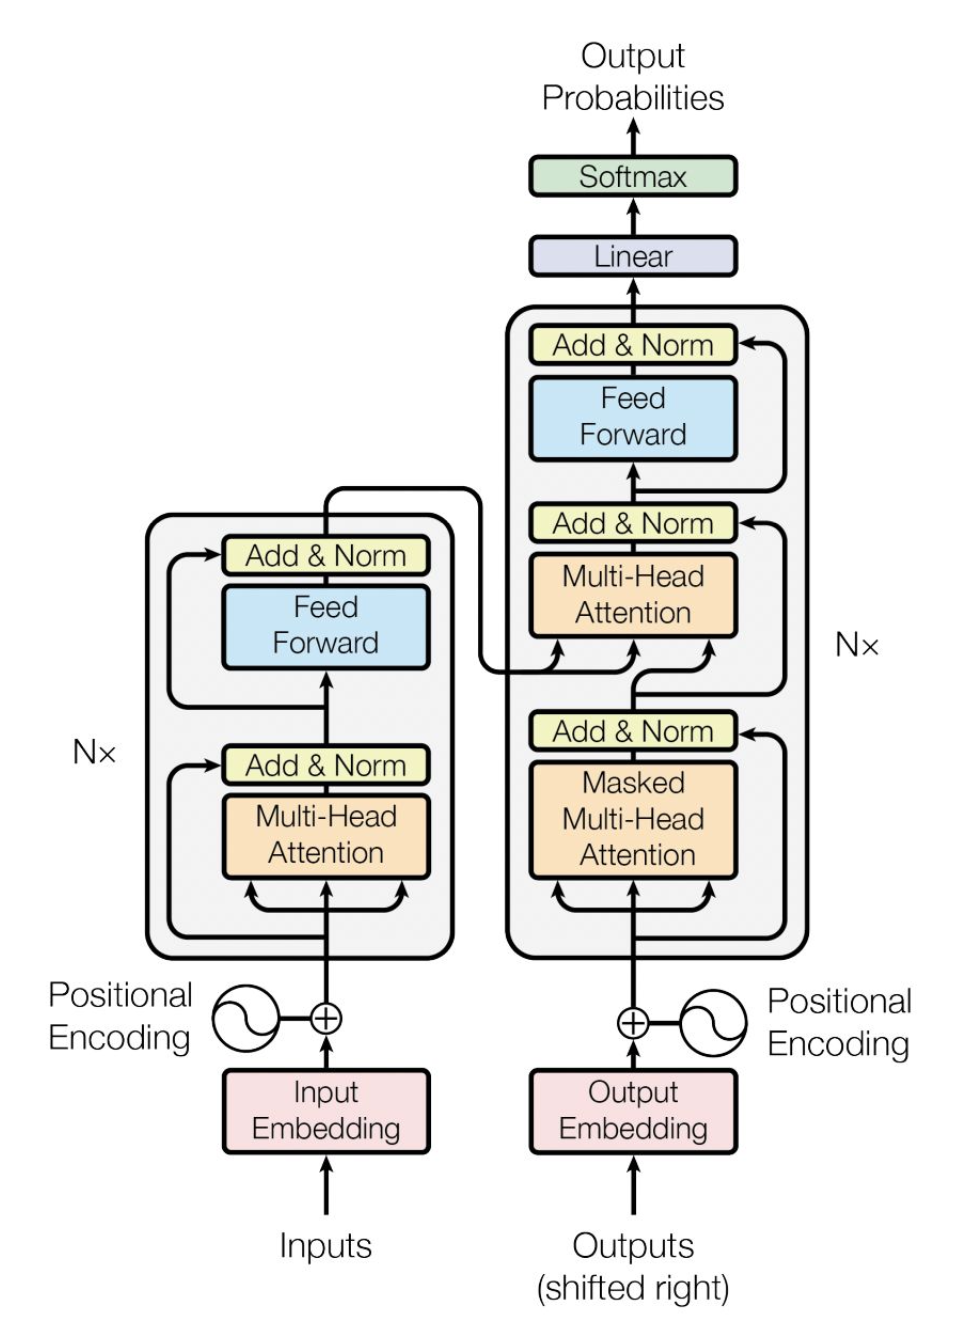
  
  Transformer架构出现，解决了自然语言处理方向，长文本下模型不能很好记忆并处理的问题

- GPT (2018/06)

  参数量：117M

  提出generative pre-training方案，将预训练广泛应用到自然语言的各项任务（QA、总结、翻译...），类似计算机视觉上基于ImageNet预训练的应用
  
- GPT2 (2019/02)

  参数量：1.5B

  提出Zero-Shot, 无需训练，仅通过Prompt（自然语言指令）即可解决自然语言的任务
  
- GPT3 (2020/05)

  参数量：175B

  不仅可以无需训练就能解决各项自然语言的任务，同时能写出让人类都很难分辨出是机器生成的文章
  
- GPT3.5 (2022/11)

  参数量：175B

  应用RLHF，让生成的内容对齐人类价值观，推出ChatGPT
  
  近几天微软一篇新文章CodeFusion,暴露GPT3.5是20B的参数量...

  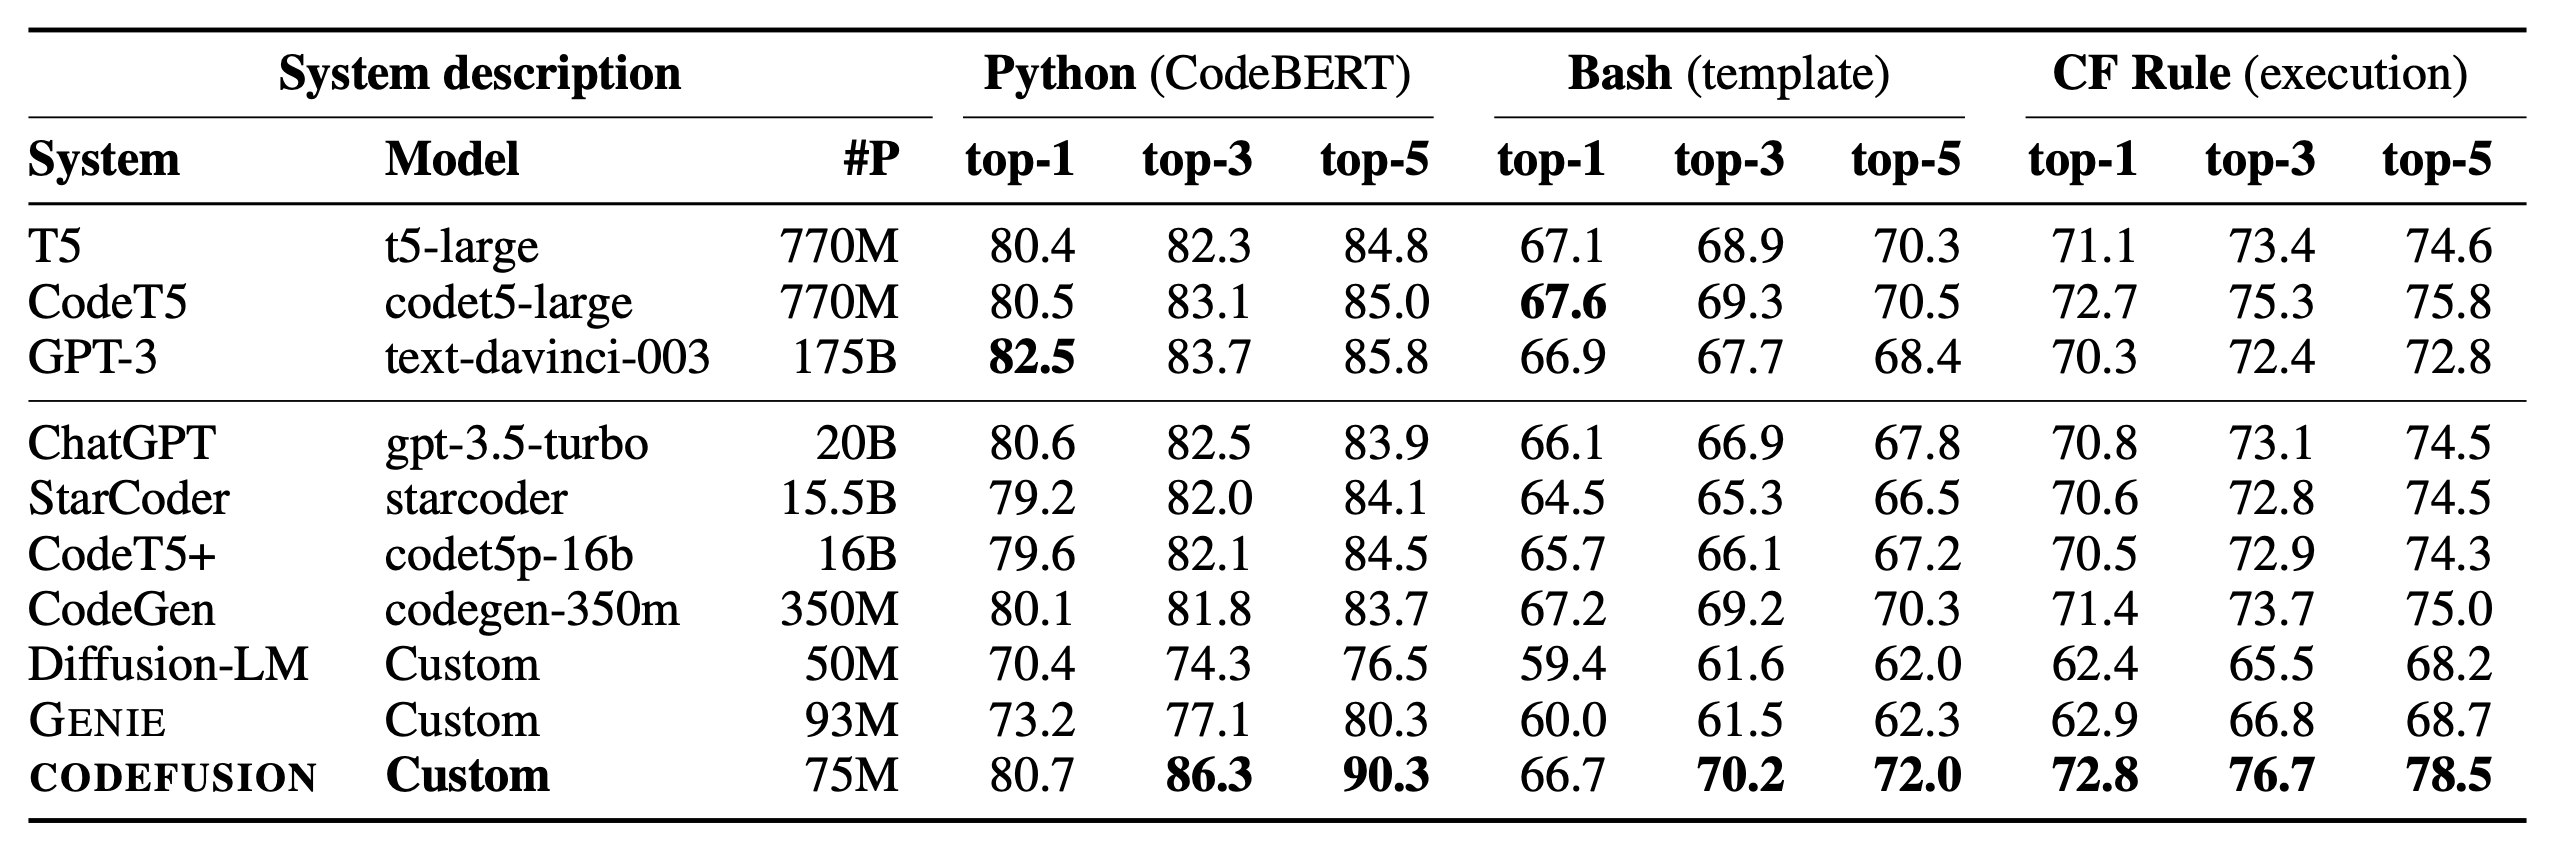
  
- GPT4 (2023/03)

  参数量：???

  实现多模态的输入输出

### 模型为什么要大？

- GPT2时期的实验中，发现模型在多项任务上效果与参数量呈正相关的现象

  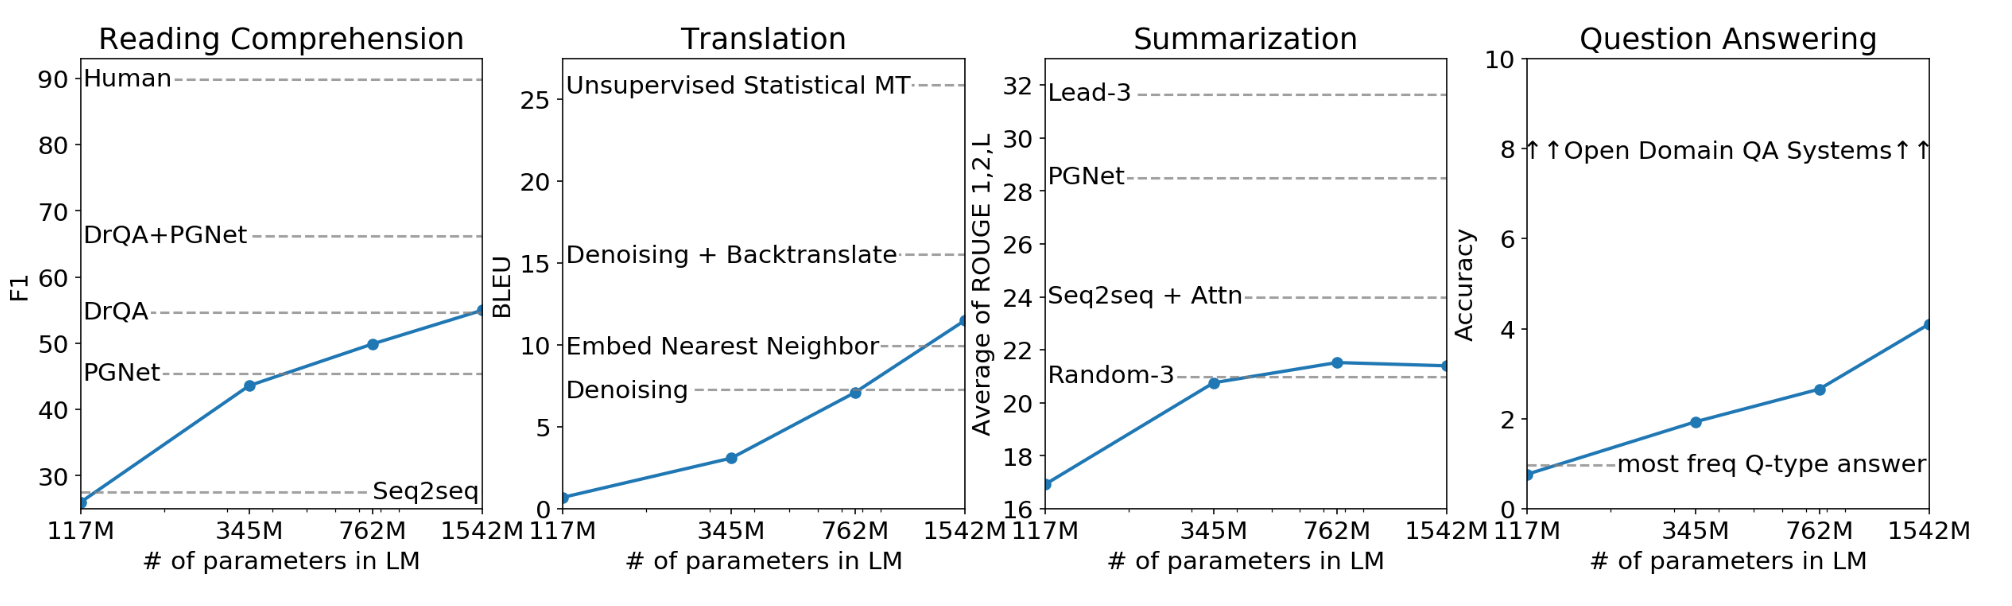

- GPT3参数量立即拉升100倍，因为在数据量不变下，随着模型的参数量增大，目标函数的损失值线性下降
  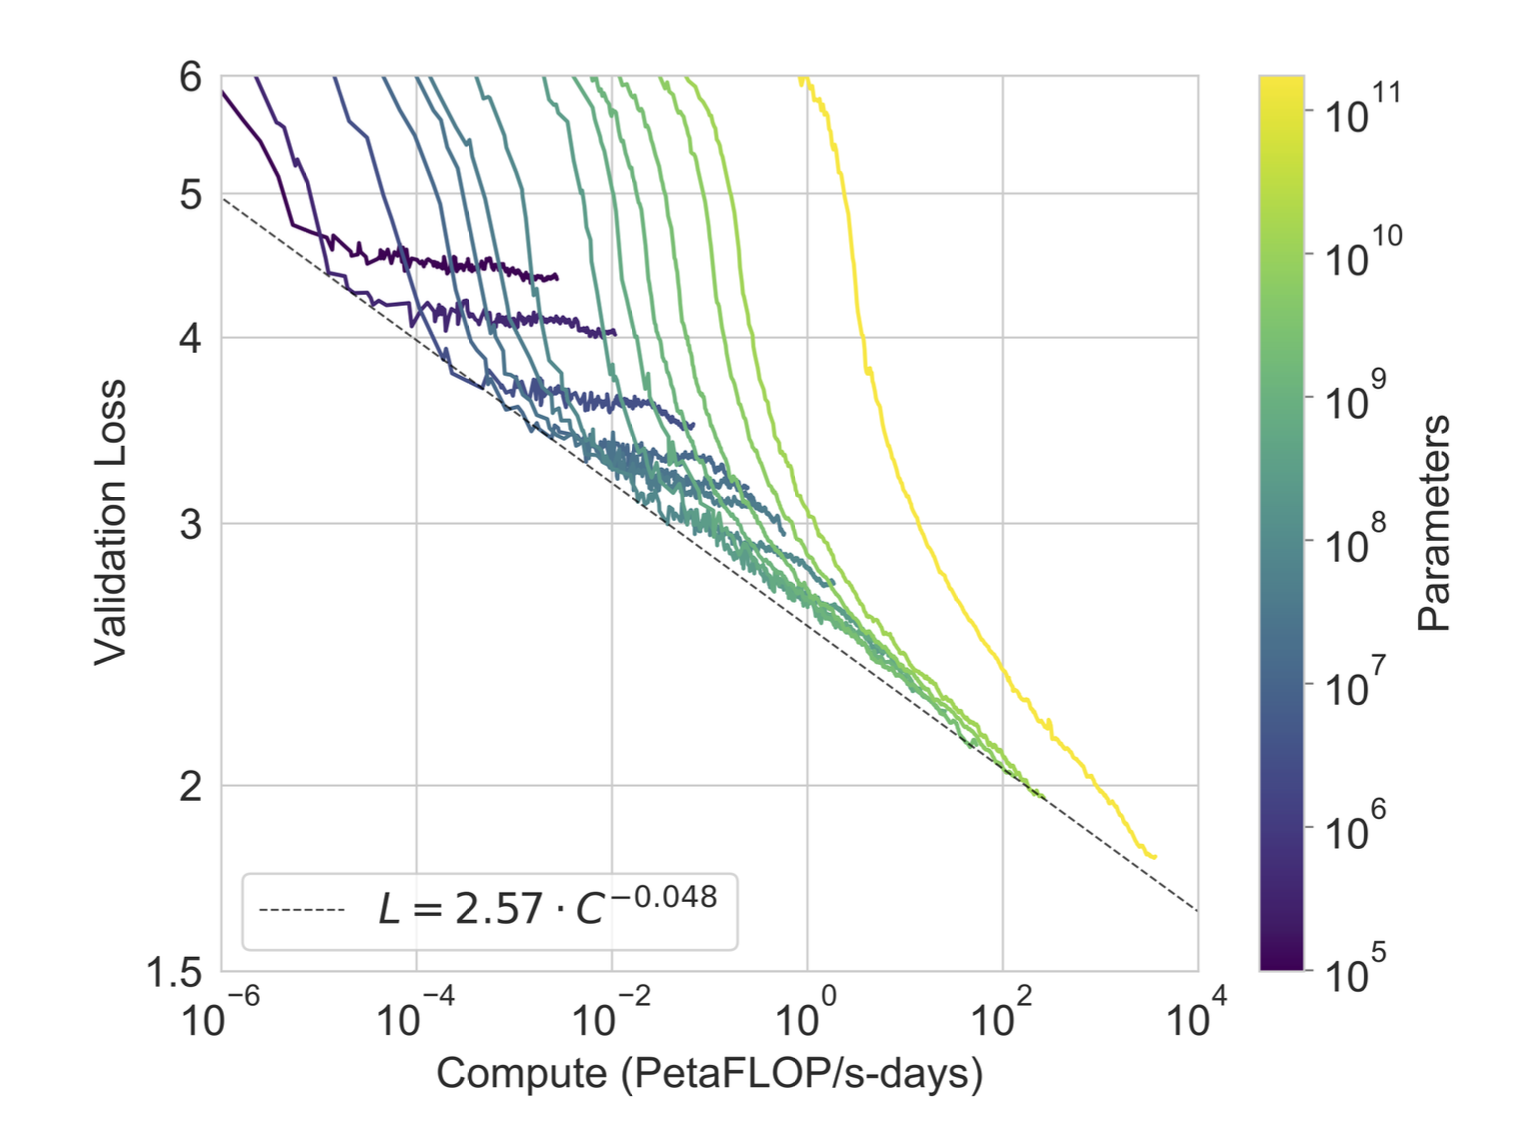
  

### 模型应该多大？

- 由于计算成本非常高，**在预算限制下**，DeepMind提出Chinchilla规则，可以推算在固定预算下应该选择多大参数量的模型和训练数据的量级.

  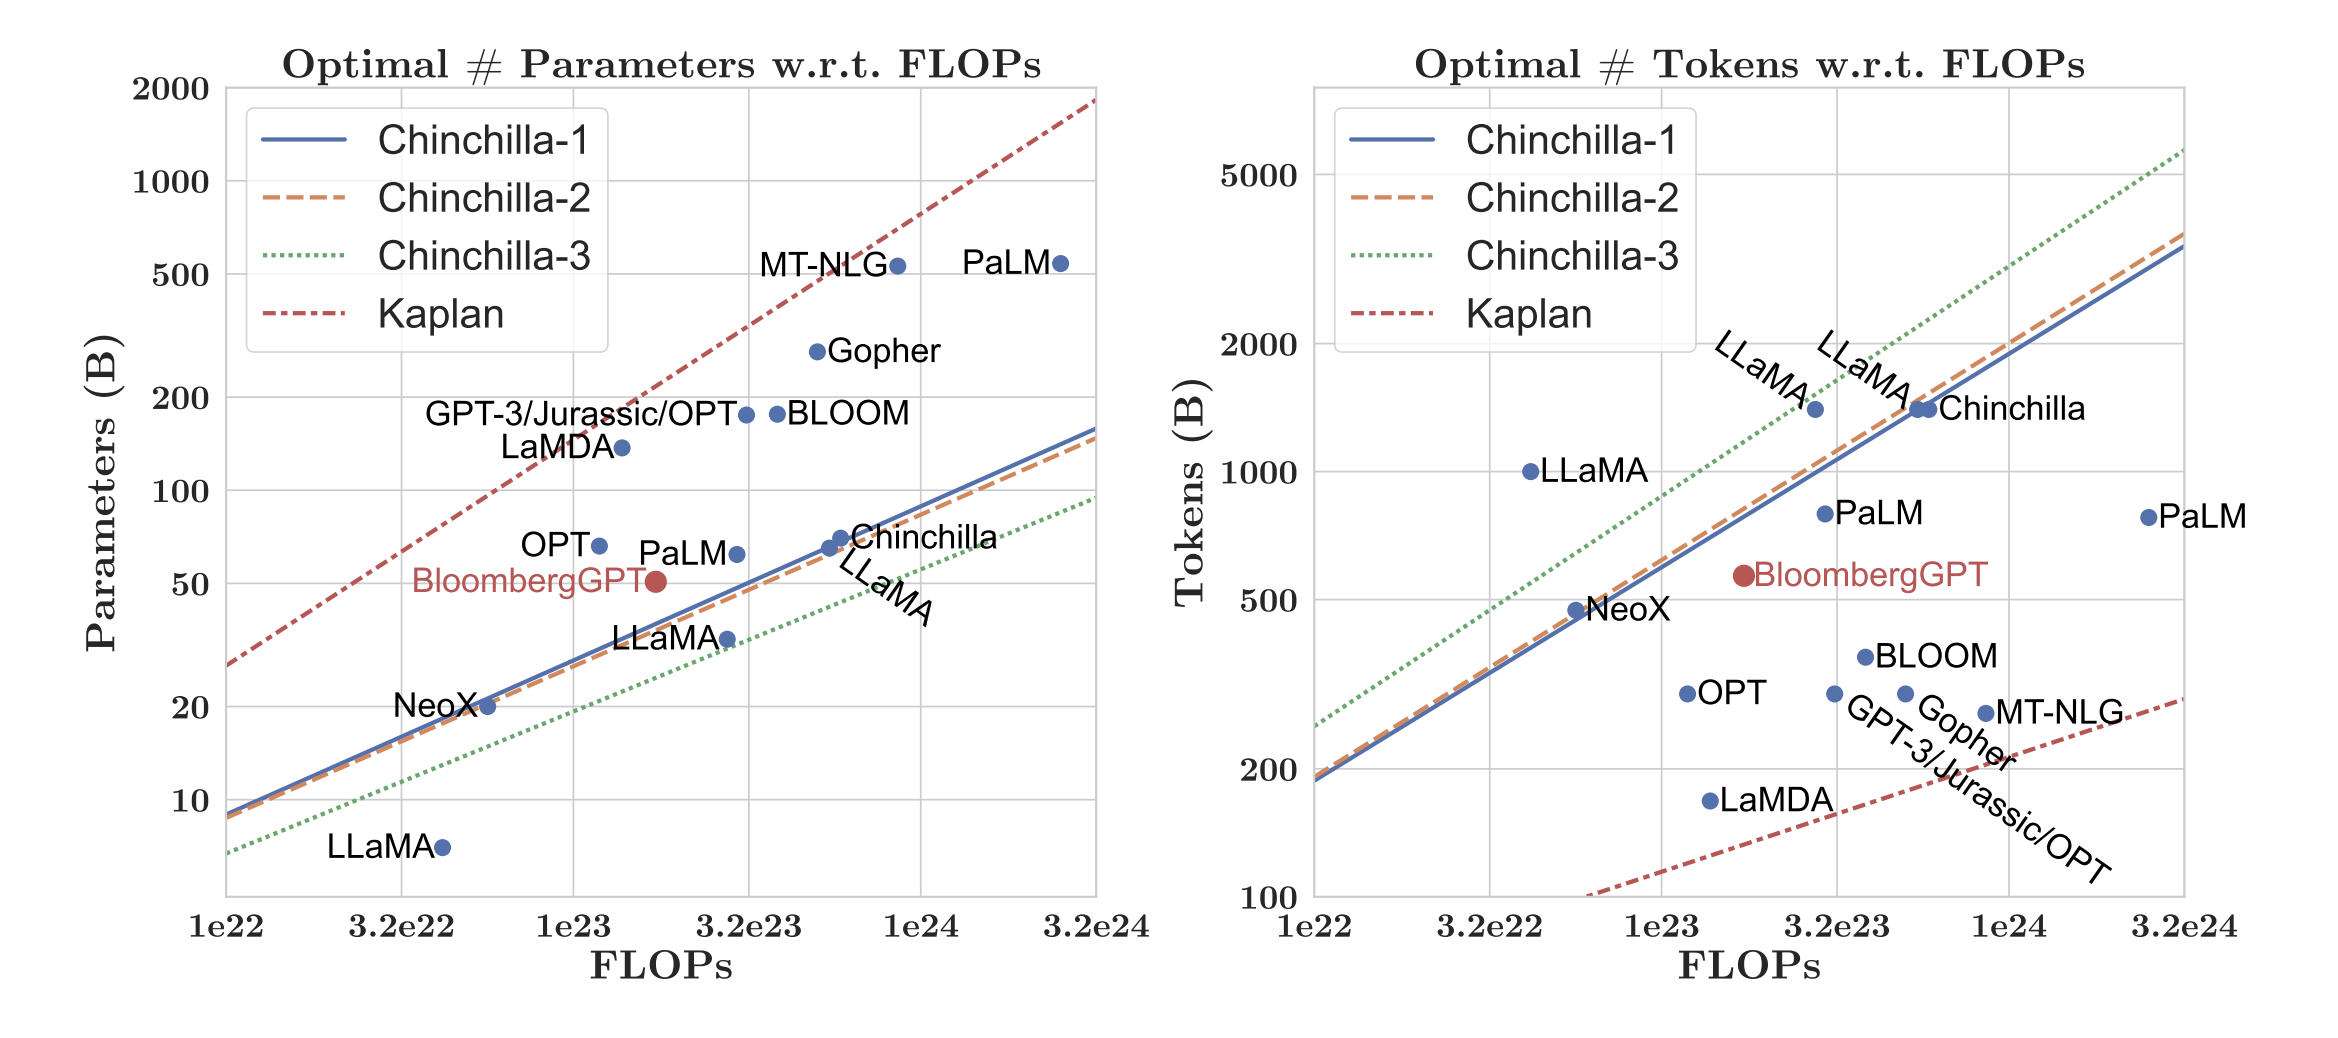

  在该规则中，模型的参数量和训练数据的量级也有一个推荐比值，即训练数据总tokens:模型参数量=20:1

  从图中能看出，Meta的LLaMA模型是在遵循该规则训练的。

## 深入了解大模型

### 大模型的类别

#### Autoencoding models

- 模型架构
  
  Encoder-only

- 建模方式
  
  Masked Language Modeling (MLM)
  
  > 通用 人工 \<MASK> 将 会 到来

  > 通用 人工 智能 将 会 到来

- 样例模型

  BERT

- 优势应用

  因为每次预测会考虑文本序列的全局表示，所以适合需要整体理解的任务；例如：语义分析、文本分类等
  

#### Autoregressive models

- 模型架构
  
  Decoder-only

- 建模方式

  Causal Language Modeling (CLM)

  > 通用 人工 智能 将 会 ？
  
  > 通用 人工 智能 将 会 到来

- 样例模型

  GPT系列

- 优势应用

  因为是通过前面的文本预测下一个文本内容，所以使得生成的内容非常流畅、自然；适合文本生成、自动补全等任务

#### Seq-to-Seq models

- 模型架构
  
  Encoder-Decoder

- 建模方式
  
  Span corruption

  > 通用 \<X> 将 会 到来
  
  > \<X> 人工 智能

- 样例模型

  T5 (Text-to-Text Transfer Transformer)

- 优势应用

  因为该架构的输入和输出都是序列，就非常适合需要将一个序列转换为另一个序列的任务；例如：机器翻译

### 大模型的训练

#### 计算量

- 计算量的单位
  
  1 petaflop/s-day = 以每秒一千万亿次浮点计算速度，计算24小时 = 2个 Nvidia A100 GPU 满载跑24小时

- GPT3 175B训练的计算量消耗

  3.64E+03 petaflop/s-day

  1024个 Nvidia A100 GPU 运行34天

  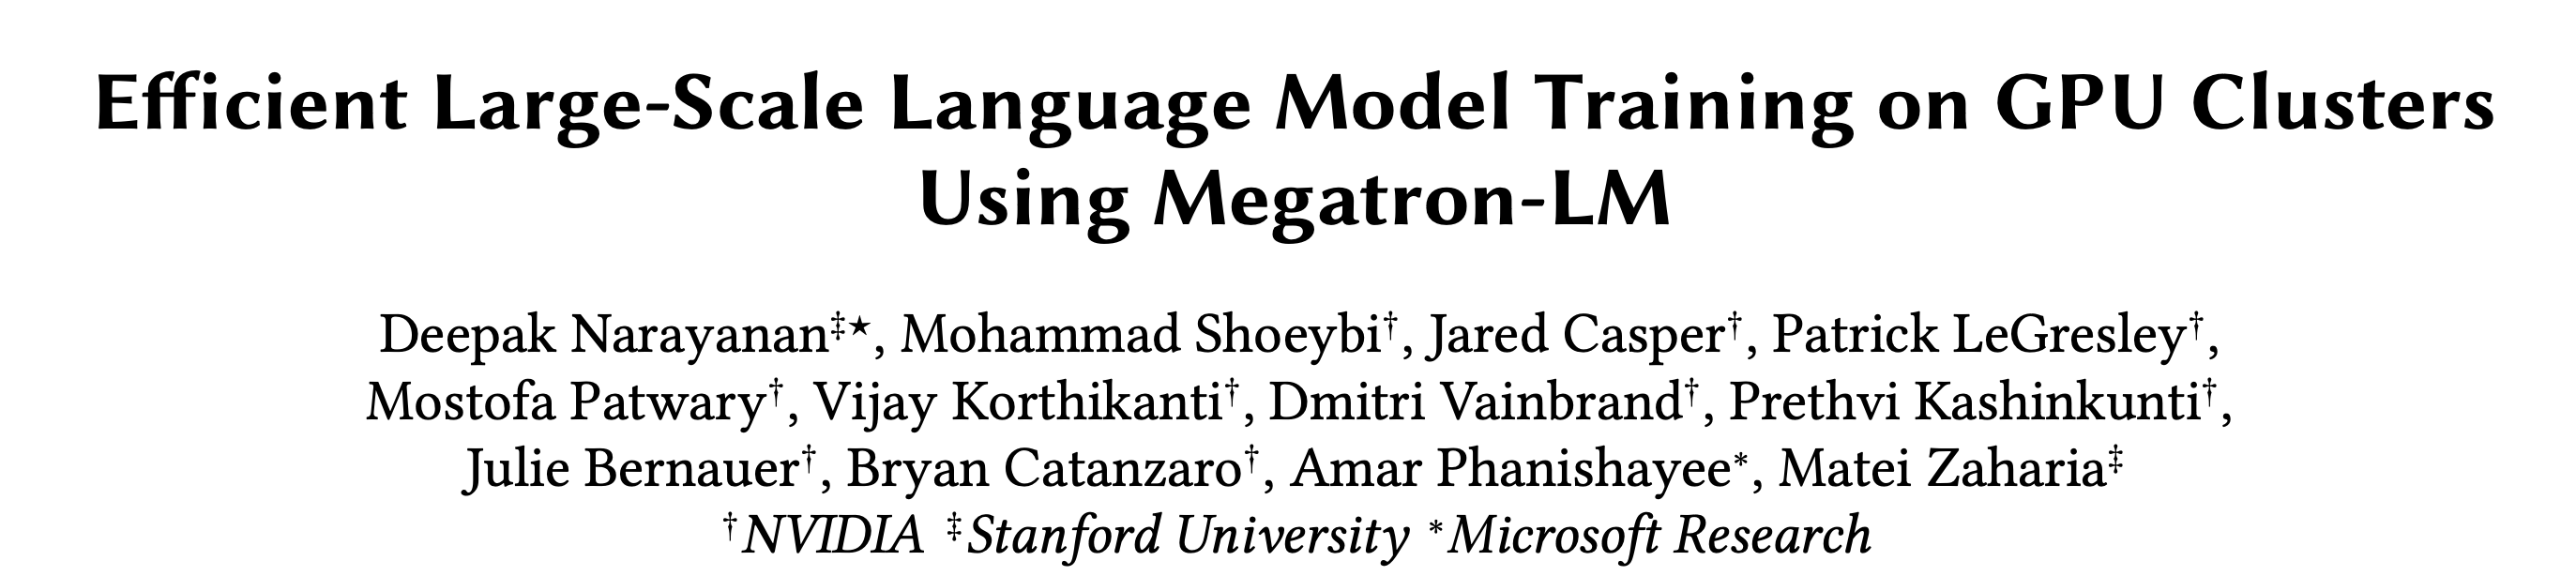

- 1个 Nvidia A100 GPU 在京东云租一个月的费用8419

  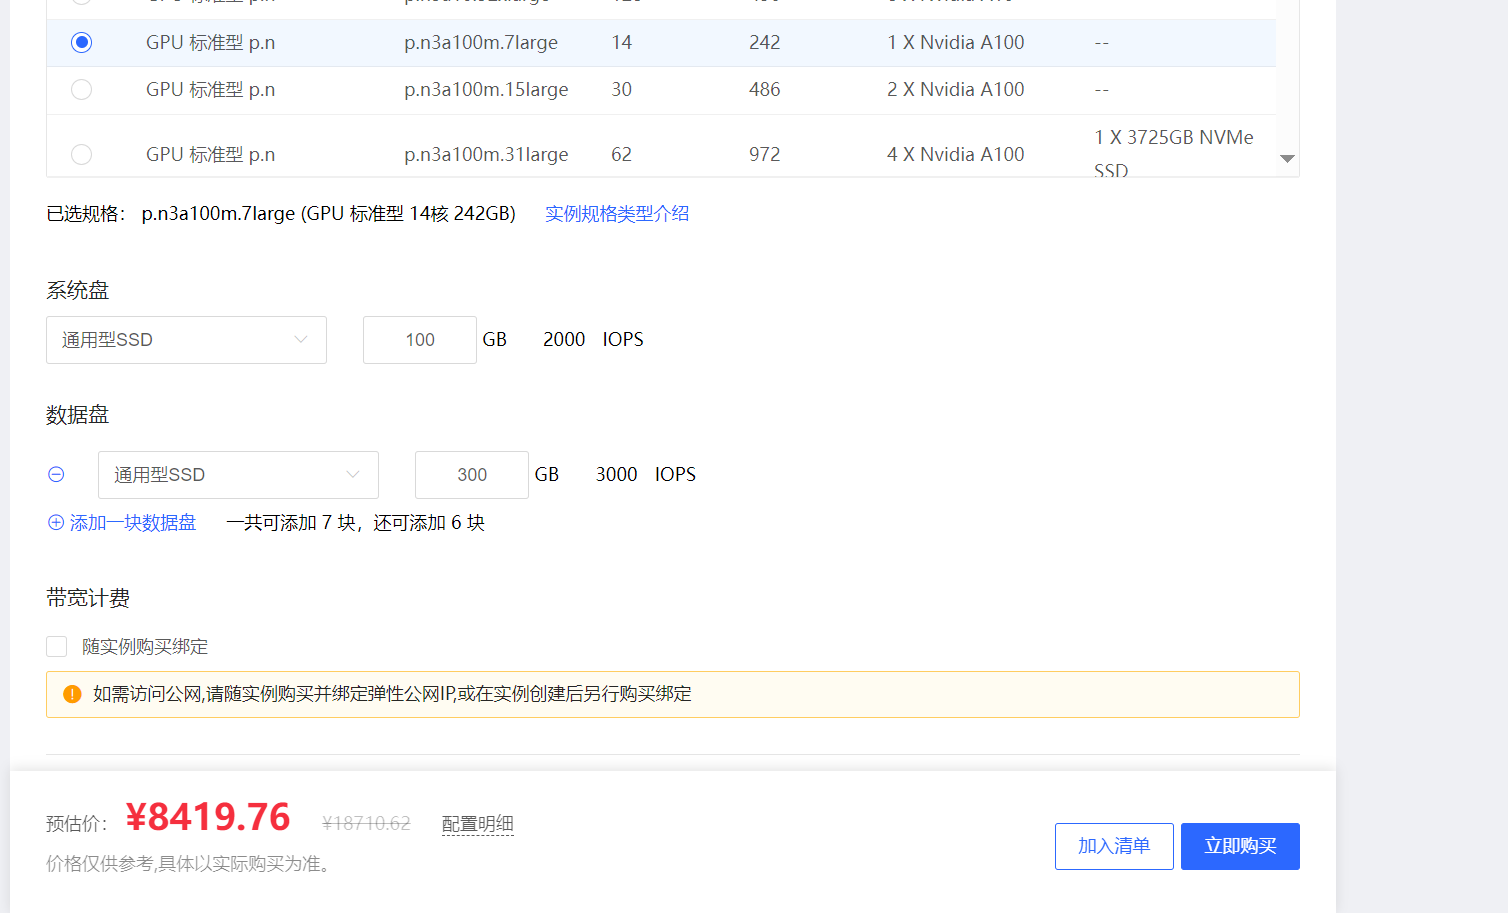

所以，大部分情况下直接使用预训练后的模型吧！

#### 存储

- 模型的存储计算

  - 1B 参数量 = 1B 32位的浮点数 = 1B * 4bytes = 10^9 * 4bytes = 4GB
  - 模型训练时，除模型参数外，每个模型参数都要存储对应的优化器状态值、梯度值以及模型中间输出的激活值等，这使每个参数需要18++ bytes；因此，1B的模型训练时要18++ GB
 
    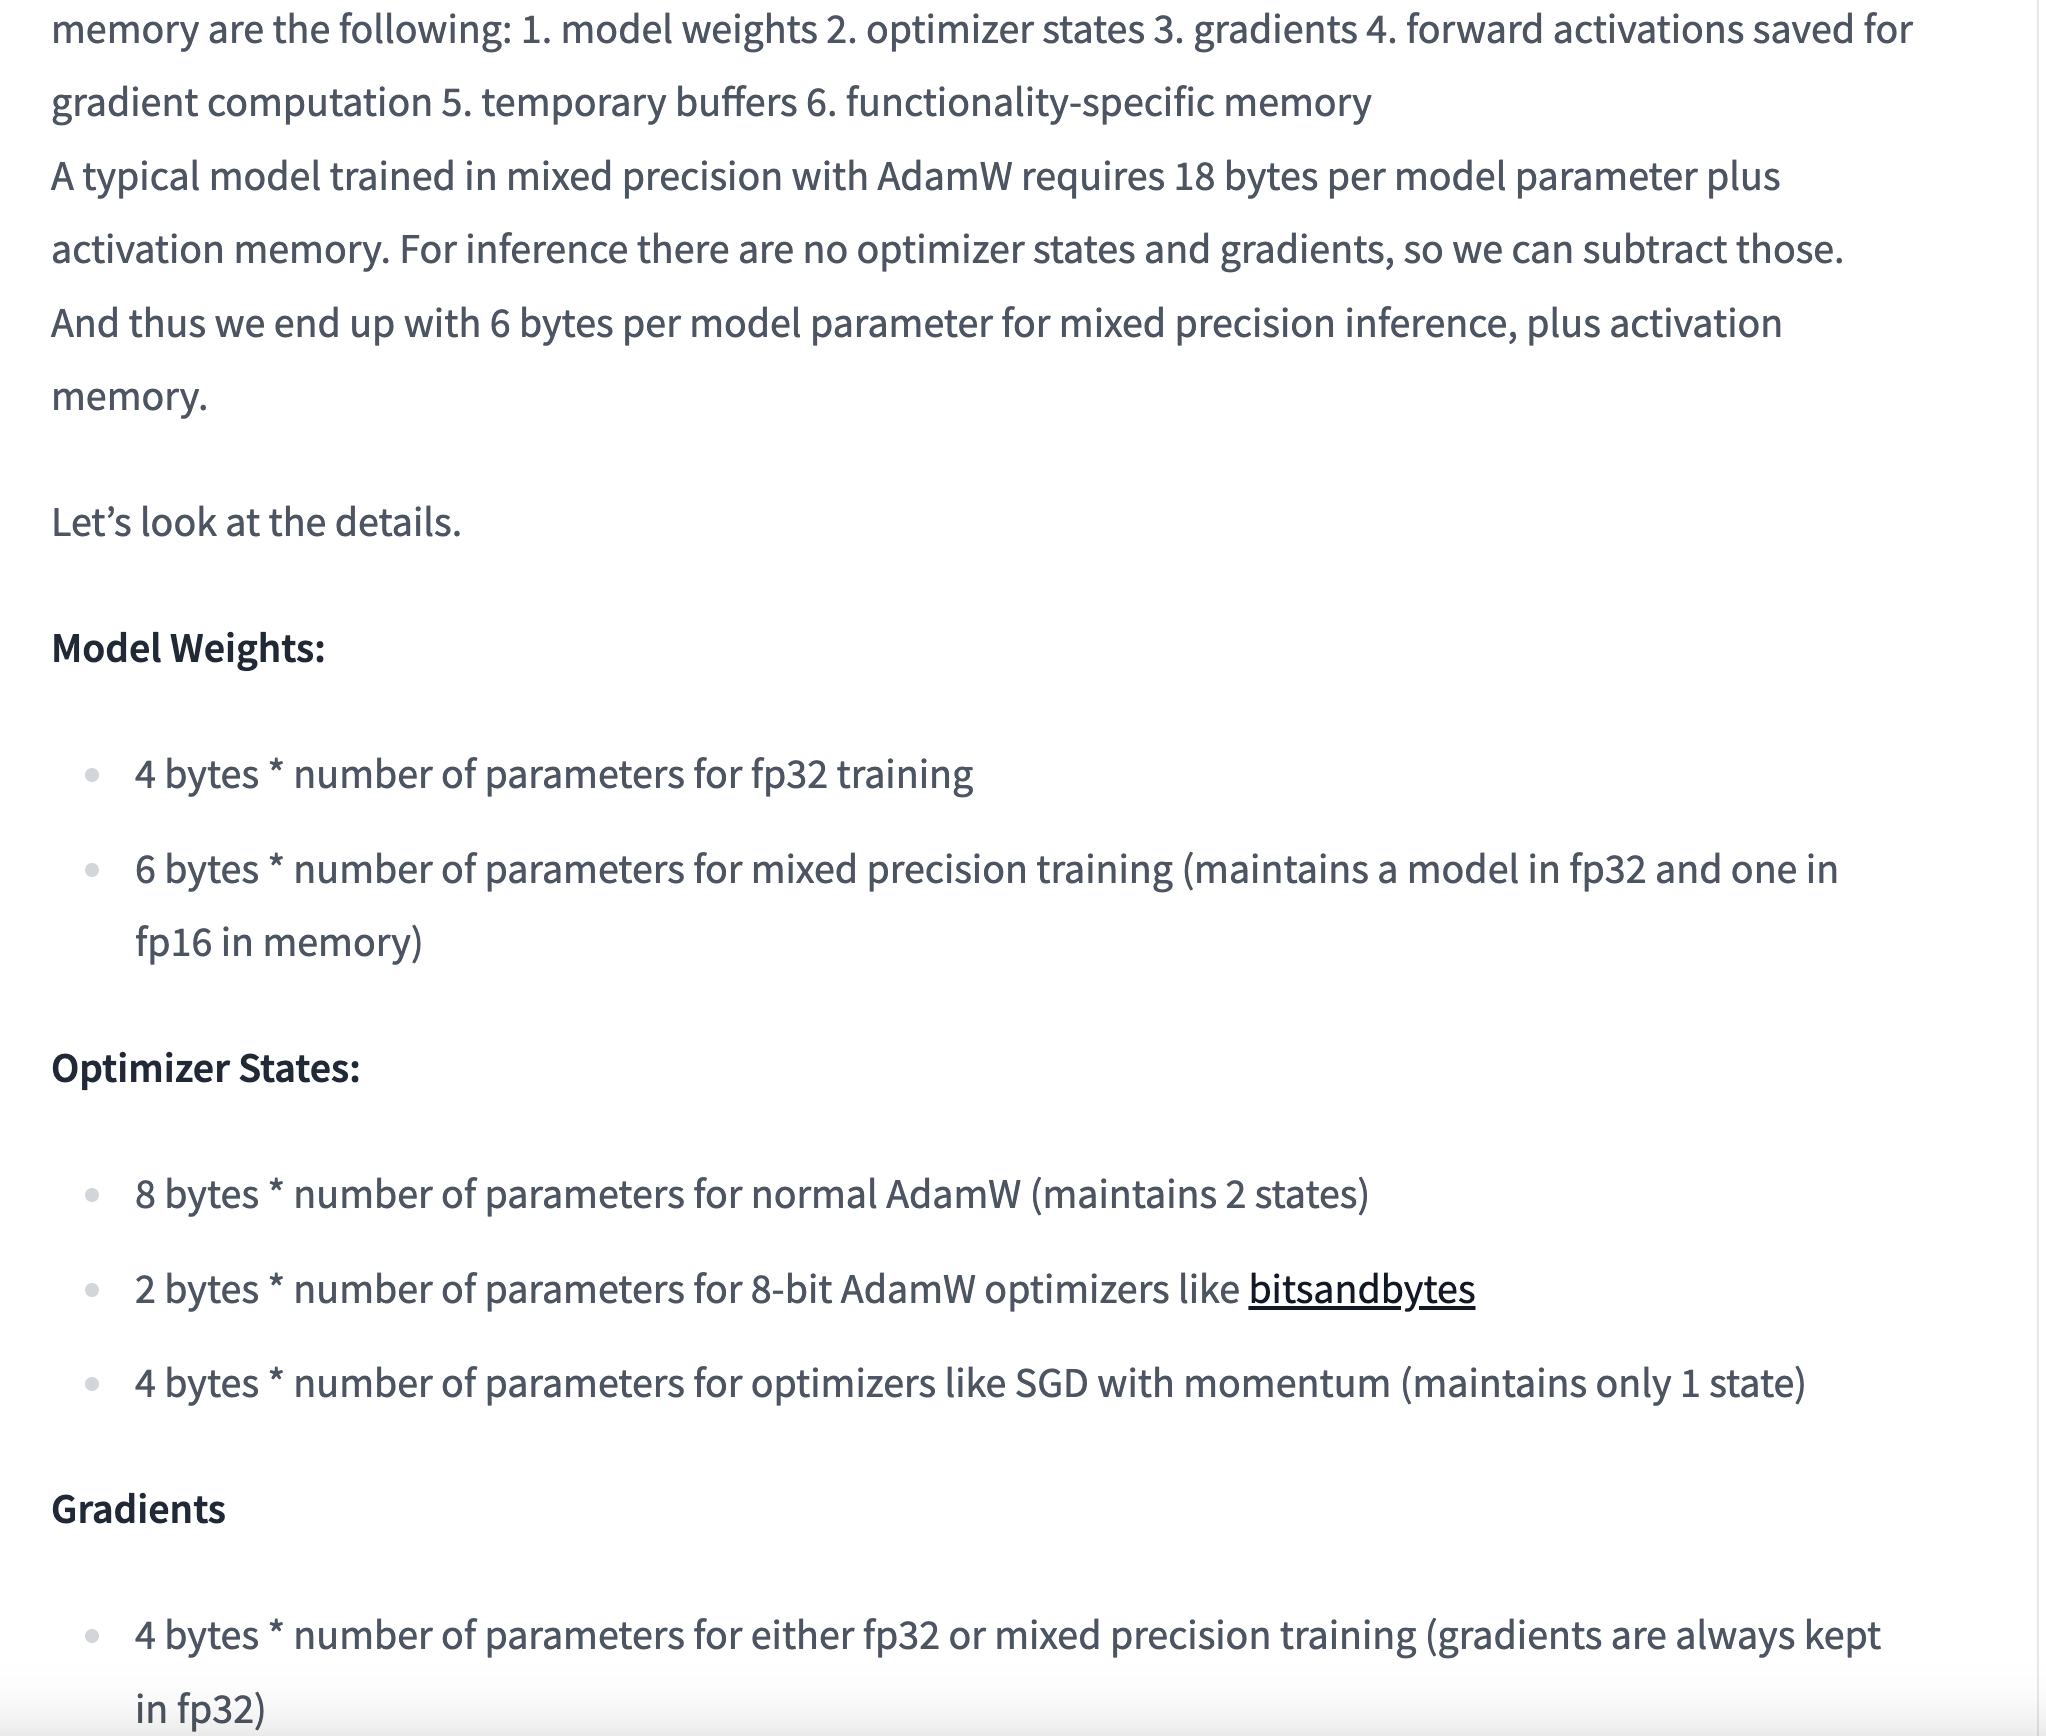

  - Nvidia A100 GPU 是80GB显存，对于大模型，显卡的数量不够都启动不了训练
 
- 存储优化
  
  - FP32

    精度高，但存储消耗大
    
    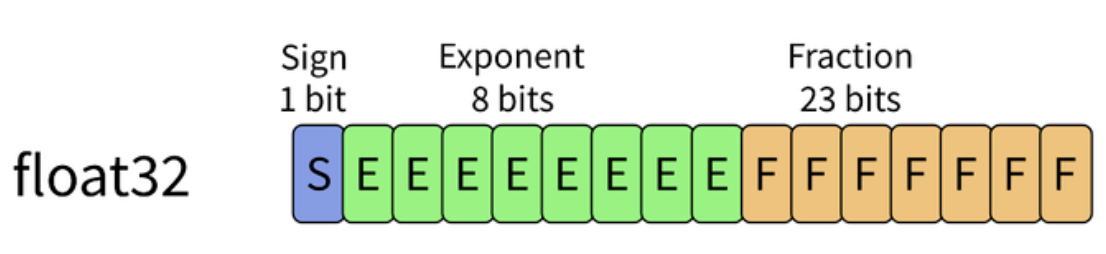
    
  - FP16

    存储消耗小，但数值范围小
    
    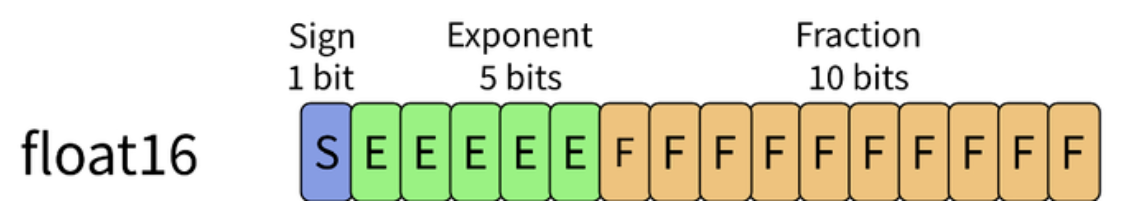
 
  - BFLOAT16

    存储消耗小、数据范围大，仅精度略低
    
    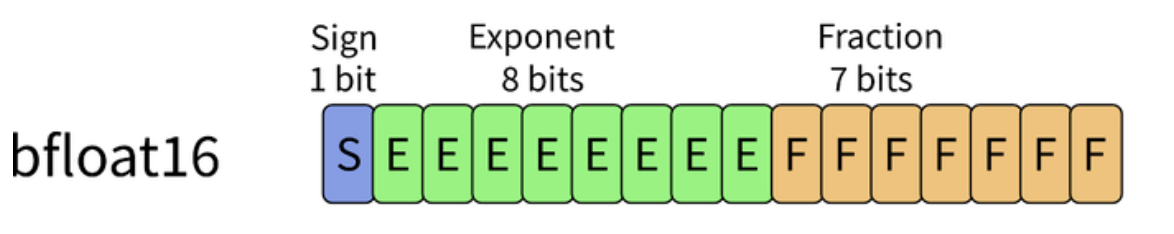
    
  - INT8

    存储消耗非常小，无小数部分，精度非常低

#### 训练数据

- GPT3 175B
  - Common Crawl语料库
  - 接近1万亿个词

### 大模型的能力

- 写作
- 问答
- 总结
- 翻译
- 信息检索
- 调用API或执行操作

  ...

### 大模型的挑战

- HHH
  - Helpful
  - Honest
  - Harmless

- out of date
- 数学计算
- 幻觉（Hallucination)

## 释放大模型的能力

### 导入必要的工具包、数据集

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys

import numpy as np
import pandas as pd
from tqdm import tqdm
import time

import openai

from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, Trainer, TrainingArguments, AutoModelForSequenceClassification, pipeline
import torch
import evaluate

from peft import LoraConfig, get_peft_model, TaskType, PeftModel

from trl import PPOTrainer, PPOConfig, AutoModelForSeq2SeqLMWithValueHead
from trl import create_reference_model
from trl.core import LengthSampler

In [2]:
openai.api_key = "sk-xxx"

In [3]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())

1
0


In [ ]:
dataset_name = 'knkarthick/dialogsum'

dataset = load_dataset(dataset_name)

dataset

### In-Context Learning

#### Zero-shot

零样本学习，即仅通过自然语言指令完成任务

小技巧
- 将任务描叙清楚且具体
- 使用分隔符标记输入的内容
- 多个任务一条一条列出
- 输出结构化

例：用户评论洞察

In [6]:
def get_completion(prompt):
    messages = [{"role": "user", "content": prompt}]
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        temperature=0,
        messages=messages
        )
    return completion.choices[0].message['content']

In [7]:
user_review = 'Item came quickly and within a day was put in the car. They look and fit great, and for the price, I’m very happy!'

In [8]:
prompt = f"""\
Identify the following items from the review text: 
- Sentiment (positive or negative or neutral)
- Topics that are being discussed
- List of key phrase for each topic

The review is delimited with triple backticks. \
Format your response as a JSON object with \
"Sentiment", "Topics" as the keys, Topics value \
is a JSON object with each topic as the keys, each \
topic value is List of it's key phrase
If the information isn't present, use "unknown" \
as the value.
Make your response as short as possible.

Review text: ```{user_review}```
"""

In [9]:
print(get_completion(prompt))

{
  "Sentiment": "positive",
  "Topics": {
    "Delivery": ["came quickly"],
    "Product appearance and fit": ["look and fit great"],
    "Price": ["for the price", "I'm very happy"]
  }
}


例：对话总结

In [10]:
# 加载Flan-T5大模型
flan_t5 = AutoModelForSeq2SeqLM.from_pretrained('llm_path/flan-t5-base')
tokenizer = AutoTokenizer.from_pretrained('llm_path/flan-t5-base')

In [11]:
# 随机挑选一个对话
index = 300
dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

In [12]:
prompt = f"""Summary dialogue, the dialogue is as follows.
dialogue: 
{dialogue}

summary:

"""

In [13]:
prompt_id = tokenizer(prompt, return_tensors='pt')
generate_ids = flan_t5.generate(prompt_id['input_ids'], 
                                max_new_tokens=200)
output = tokenizer.decode(generate_ids[0], skip_special_tokens=True)

dash_line = '-'*100
print(dash_line)
print(f'Input Prompt:\n{prompt}')
print(dash_line)
print(f'Human Summary:\n{summary}')
print(dash_line)
print(f'Model Summary-Zero Shot:\n{output}')

----------------------------------------------------------------------------------------------------
Input Prompt:
Summary dialogue, the dialogue is as follows.
dialogue: 
#Person1#: I cannot imagine if Trump were to be our President again.
#Person2#: I am proud to say that he is our President, and I will be really happy if he could be re-elected.
#Person1#: You voted for him, right?
#Person2#: Did you vote for him, because I know that I did.
#Person1#: I am not sure about this.
#Person2#: I have nothing but faith in Trump.
#Person1#: What?
#Person2#: I am pretty sure he will make America great again!
#Person1#: Well, though we do need some change in this country, I don't think he is the right person.
#Person2#: Our country is already changing as it is.
#Person1#: You are right about this.
#Person2#: I trust that he will take good care of our country.
#Person1#: Well, I don't think so. I will vote for Biden anyway.

summary:


-----------------------------------------------------------

在对话总结上，Flan-T5模型通过Zero-Shot并不能达到一个很好的效果

#### One-shot/Few-shot

- 当不能很好的描叙需求或者回答的结果不满意时，可以尝试给一些样例让模型理解

例：模仿写作风格

In [14]:
prompt = f"""
Your task is to answer in a consistent style.

<child>: Teach me about patience.

<grandparent>: The river that carves the deepest \ 
valley flows from a modest spring; the \ 
grandest symphony originates from a single note; \ 
the most intricate tapestry begins with a solitary thread.

<child>: Teach me about love.
"""

print(get_completion(prompt))

<grandparent>: Love is a gentle breeze that caresses the soul, a warm embrace that brings comfort, and a beacon of light that guides us through the darkest of times. It is a selfless act of kindness, a bond that connects hearts, and a language that transcends words. Love is patient, understanding, and unconditional. It is the foundation upon which relationships are built and the fuel that keeps them strong.


例：对话总结

In [14]:
def llm_generate(llm, tokenizer, prompt):
    input = tokenizer(prompt, return_tensors='pt')
    generate = llm.generate(input_ids=input['input_ids'], max_new_tokens=200)
    output = tokenizer.decode(generate[0], skip_special_tokens=True)
    return output

In [15]:
prompt = ""
for i in range(5, 20, 5):
    dialogue_example = dataset['test'][index-i]['dialogue']
    summary_example = dataset['test'][index-i]['summary']
    prompt += f"""
Summary dialogue, the dialogue is as follows.
dialogue: 
{dialogue_example}

Summary:

{summary_example}

"""
    
prompt = f"""{prompt}

dialogue:
{dialogue}

Summary:

"""

output = llm_generate(flan_t5, tokenizer, prompt)
print(dash_line)
print(f'Input Prompt:\n{prompt}')
print(dash_line)
print(f'Human Summary:\n{summary}')
print(dash_line)
print(f'Model Summary - Few Shot:\n{output}')

Token indices sequence length is longer than the specified maximum sequence length for this model (993 > 512). Running this sequence through the model will result in indexing errors


----------------------------------------------------------------------------------------------------
Input Prompt:

Summary dialogue, the dialogue is as follows.
dialogue: 
#Person1#: Carol telephone.
#Person2#: Who is it?
#Person1#: I don't know, wait a second. May I ask who's calling please? Carrollite Susan.
#Person2#: Oh, I'm taking a shower can you ask her if it's important?
#Person1#: Sorry Susan, Carol can't come to the phone right now, is there something I can help you with? Oh, I see, Carol she wants to know if the party is tonight or tomorrow night.
#Person2#: Tell her it is tomorrow night at 8:30 at Jills House, tell her to bring a dessert if she wants.
#Person1#: She said it is tomorrow night at 8:30 at Jills House, she said you could bring a dessert if you want. Sure no problem have a good evening. Bye.

Summary:

Carol is taking a shower when Carol calls her, so #Person1# answers the telephone and tells her the party time.


Summary dialogue, the dialogue is as follows.
d

通过Few-shot后，Flan-t5学会了总结的风格，但总结的效果差；如果给模型的样例达到3-5个还没有效果，说明仅靠Prompt就不能解决问题了

### Post-Training

当Zero-shot/One-shot/Few-shot等Prompt方法不能满足需求时，**再去考虑**模型微调。

#### Full Fine-Tuning

模型的所有参数都会进行重新训练，训练的存储要求和预训练一样，代价比较高

In [16]:
def print_number_of_trainable_model_parameters(model):
    trainable_parameters = 0
    all_parameters = 0
    for _, param in model.named_parameters():
        all_parameters += param.numel()
        if param.requires_grad:
            trainable_parameters += param.numel()
    print(f'trainable model parameters: {trainable_parameters}\nall model parameters: {all_parameters}\npercentage of trainable parameters: {trainable_parameters/all_parameters*100}%')

In [17]:
print_number_of_trainable_model_parameters(flan_t5)

trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable parameters: 100.0%


In [ ]:
# 准备训练数据
def tokenize_func(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example['dialogue']]
    example['input_ids'] = tokenizer(prompt, padding='max_length', truncation=True, return_tensors='pt').input_ids
    example['labels'] = tokenizer(example['summary'], padding='max_length', truncation=True, return_tensors='pt').input_ids
    return example
    
tokenized_dataset = dataset.map(tokenize_func, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['id', 'dialogue', 'summary', 'topic'])
tokenized_dataset

In [19]:
# 开始模型微调训练
output_dir = f'./checkpoints/dialogue-summary-training-{str(int(time.time()))}'

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    weight_decay=0.01,
    num_train_epochs=1,
    max_steps=5,
    # torch_compile=True, # BackendCompilerFailed: debug_wrapper raised OSError: [Errno 28] No space left on device
    logging_steps=1)

trainer = Trainer(
    model=flan_t5,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation']
)

trainer.train()

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


CODECARBON : Failed to match CPU TDP constant. Falling back on a global constant.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/transformers/src/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
2023-11-02 09:01:44,227 - apscheduler.scheduler - INFO - Added job "BaseEmissionsTracker._measure_power" to job store "default"
2023-11-02 09:01:44,228 - apscheduler.scheduler - INFO - Scheduler started


2023-11-02 09:01:47,790 - apscheduler.scheduler - INFO - Scheduler has been shut down


TrainOutput(global_step=5, training_loss=47.19178924560547, metrics={'train_runtime': 3.5687, 'train_samples_per_second': 11.209, 'train_steps_per_second': 1.401, 'total_flos': 27390294097920.0, 'train_loss': 47.19178924560547, 'epoch': 0.0})

In [20]:
# 加载已经多次训练的模型
flan_t5_instruct = AutoModelForSeq2SeqLM.from_pretrained('checkpoint_path')

In [21]:
# 微调后的模型效果
dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

start_prompt = 'Summarize the following conversation.\n\n'
end_prompt = '\n\nSummary: '
prompt = start_prompt + dialogue + end_prompt

output = llm_generate(flan_t5_instruct, tokenizer, prompt)
dash_line = '-'*100
print(dash_line)
print(f'Input Prompt:\n{prompt}')
print(dash_line)
print(f'Human Summary:\n{summary}')
print(dash_line)
print(f'Full fine-tuning Model Summary:\n{output}')

----------------------------------------------------------------------------------------------------
Input Prompt:
Summarize the following conversation.

#Person1#: I cannot imagine if Trump were to be our President again.
#Person2#: I am proud to say that he is our President, and I will be really happy if he could be re-elected.
#Person1#: You voted for him, right?
#Person2#: Did you vote for him, because I know that I did.
#Person1#: I am not sure about this.
#Person2#: I have nothing but faith in Trump.
#Person1#: What?
#Person2#: I am pretty sure he will make America great again!
#Person1#: Well, though we do need some change in this country, I don't think he is the right person.
#Person2#: Our country is already changing as it is.
#Person1#: You are right about this.
#Person2#: I trust that he will take good care of our country.
#Person1#: Well, I don't think so. I will vote for Biden anyway.

Summary: 
------------------------------------------------------------------------------

通过指令微调后，模型总结效果大幅提升，但每一个任务都要一个比较大的训练成本

#### PEFT（Parameter efficient fine-tuning）-LoRA

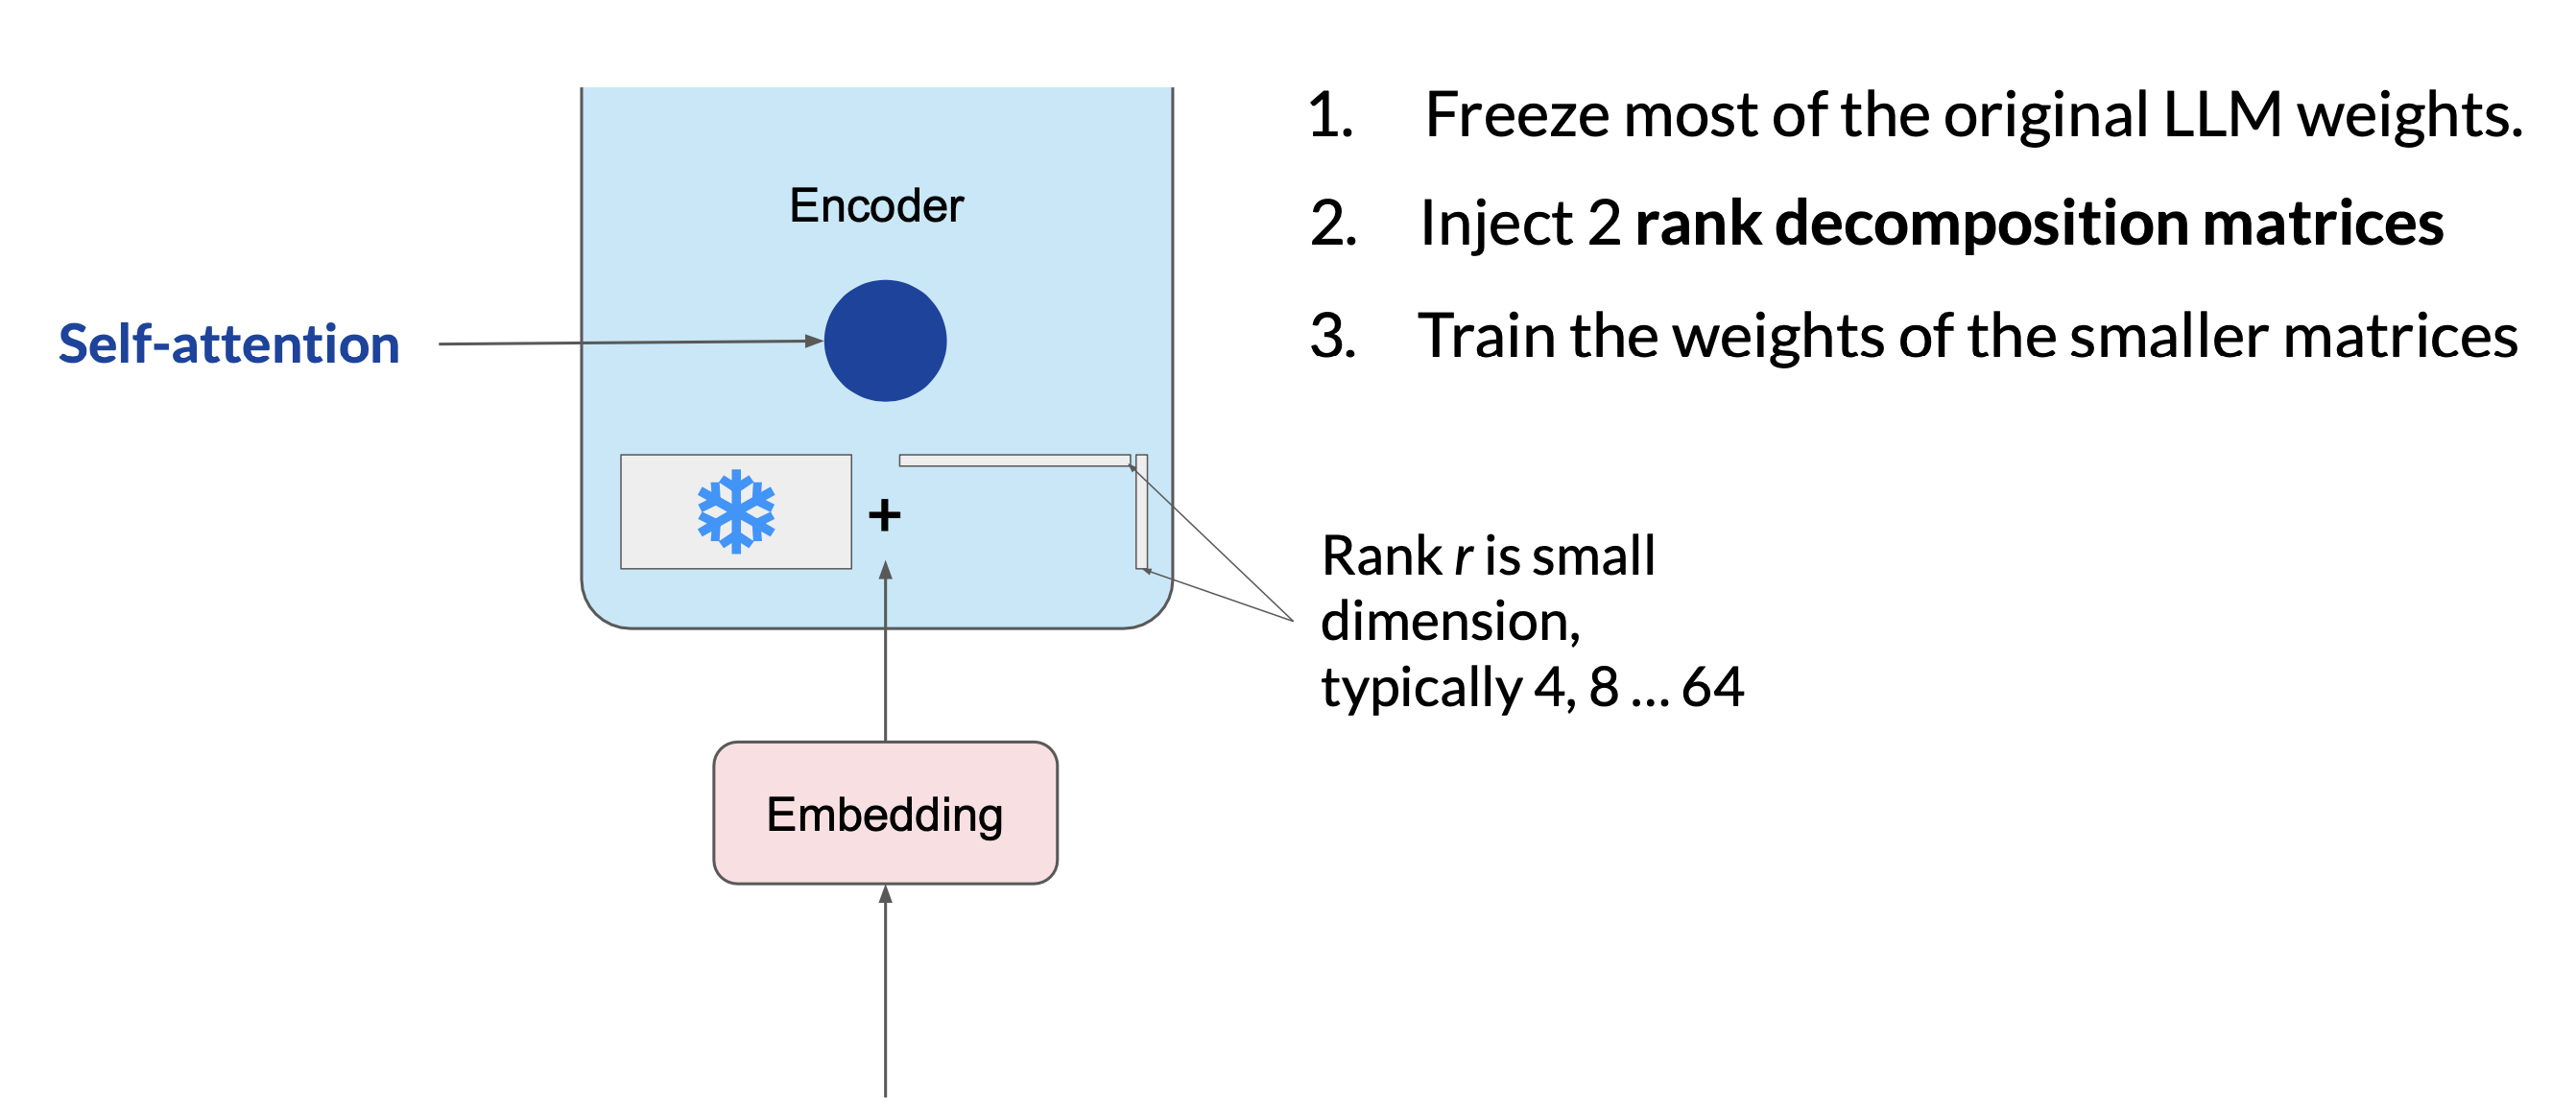

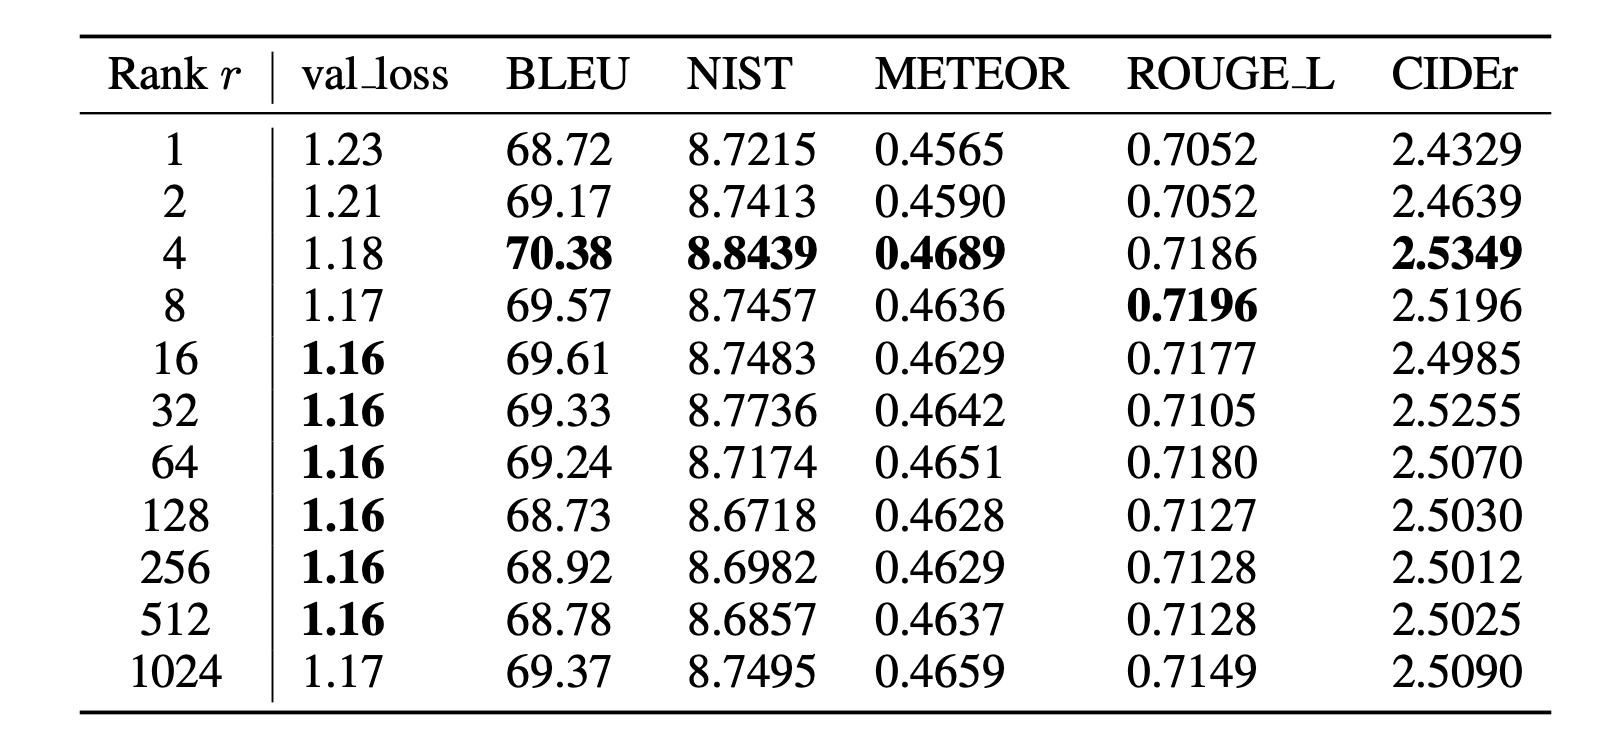

通过固定模型的原始参数，单独训练两个低秩的矩阵，可以大幅降低训练量，而且实验显示效果与全参数量的训练差别不太大;同时，实验显示矩阵的秩不是一直增大会好

In [26]:
flan_t5 = AutoModelForSeq2SeqLM.from_pretrained('llm_path/flan-t5-base')

In [27]:
# 将LoRA应用到模型

loraConfig = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=['q', 'v'],
    lora_dropout=0.05,
    task_type=TaskType.SEQ_2_SEQ_LM
)

peft_model = get_peft_model(flan_t5, loraConfig)

In [28]:
print_number_of_trainable_model_parameters(peft_model)

trainable model parameters: 3538944
all model parameters: 251116800
percentage of trainable parameters: 1.4092820552029972%


In [29]:
# 基于LoRA的模型微调训练

output_dir = f'./checkpoints/peft-dialogue-summary-training-{str(int(time.time()))}'

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-3,
    auto_find_batch_size=True,
    # weight_decay=0.01,
    num_train_epochs=1,
    max_steps=5,
    logging_steps=1)

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation']
)

peft_trainer.train()

2023-11-02 06:53:51,331 - codecarbon.emissions_tracker - WARNING - CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2023-11-02 06:53:52,633 - codecarbon.emissions_tracker - WARNING - CODECARBON : Failed to match CPU TDP constant. Falling back on a global constant.
2023-11-02 06:53:52,636 - apscheduler.scheduler - INFO - Adding job tentatively -- it will be properly scheduled when the scheduler starts
/transformers/src/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
2023-11-02 06:53:53,306 - apscheduler.scheduler - INFO - Added job "BaseEmissionsTracker._measure_power" to job store "default"
2023-11-02 06:53:53,310 - apscheduler.scheduler - INFO - Scheduler started


2023-11-02 06:53:55,578 - apscheduler.scheduler - INFO - Scheduler has been shut down


TrainOutput(global_step=5, training_loss=43.43620071411133, metrics={'train_runtime': 2.2761, 'train_samples_per_second': 17.574, 'train_steps_per_second': 2.197, 'total_flos': 27825159536640.0, 'train_loss': 43.43620071411133, 'epoch': 0.0})

In [30]:
# 加载训练多次的LoRA模型
peft_model = PeftModel.from_pretrained(flan_t5,
                                       'checkpoint_path',
                                       lora_config=loraConfig,
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=True)

2023-11-02 06:55:52,860 - peft.tuners.tuners_utils - INFO - Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!


In [34]:
def llm_generate(llm, tokenizer, prompt):
    input = tokenizer(prompt, return_tensors='pt').to('cuda')
    generate = llm.generate(input_ids=input['input_ids'], max_new_tokens=200)
    output = tokenizer.decode(generate[0], skip_special_tokens=True)
    return output

In [37]:
# LoRA微调后的模型效果

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

start_prompt = 'Summarize the following conversation.\n\n'
end_prompt = '\n\nSummary: '
prompt = start_prompt + dialogue + end_prompt

output = llm_generate(peft_model, tokenizer, prompt)
dash_line = '-'*100
print(dash_line)
print(f'Input Prompt:\n{prompt}')
print(dash_line)
print(f'Human Summary:\n{summary}')
print(dash_line)
print(f'PEFT Model Summary:\n{output}')

----------------------------------------------------------------------------------------------------
Input Prompt:
Summarize the following conversation.

#Person1#: I cannot imagine if Trump were to be our President again.
#Person2#: I am proud to say that he is our President, and I will be really happy if he could be re-elected.
#Person1#: You voted for him, right?
#Person2#: Did you vote for him, because I know that I did.
#Person1#: I am not sure about this.
#Person2#: I have nothing but faith in Trump.
#Person1#: What?
#Person2#: I am pretty sure he will make America great again!
#Person1#: Well, though we do need some change in this country, I don't think he is the right person.
#Person2#: Our country is already changing as it is.
#Person1#: You are right about this.
#Person2#: I trust that he will take good care of our country.
#Person1#: Well, I don't think so. I will vote for Biden anyway.

Summary: 
------------------------------------------------------------------------------

#### RLHF

通过人工对生成结果的反馈，构建奖励模型

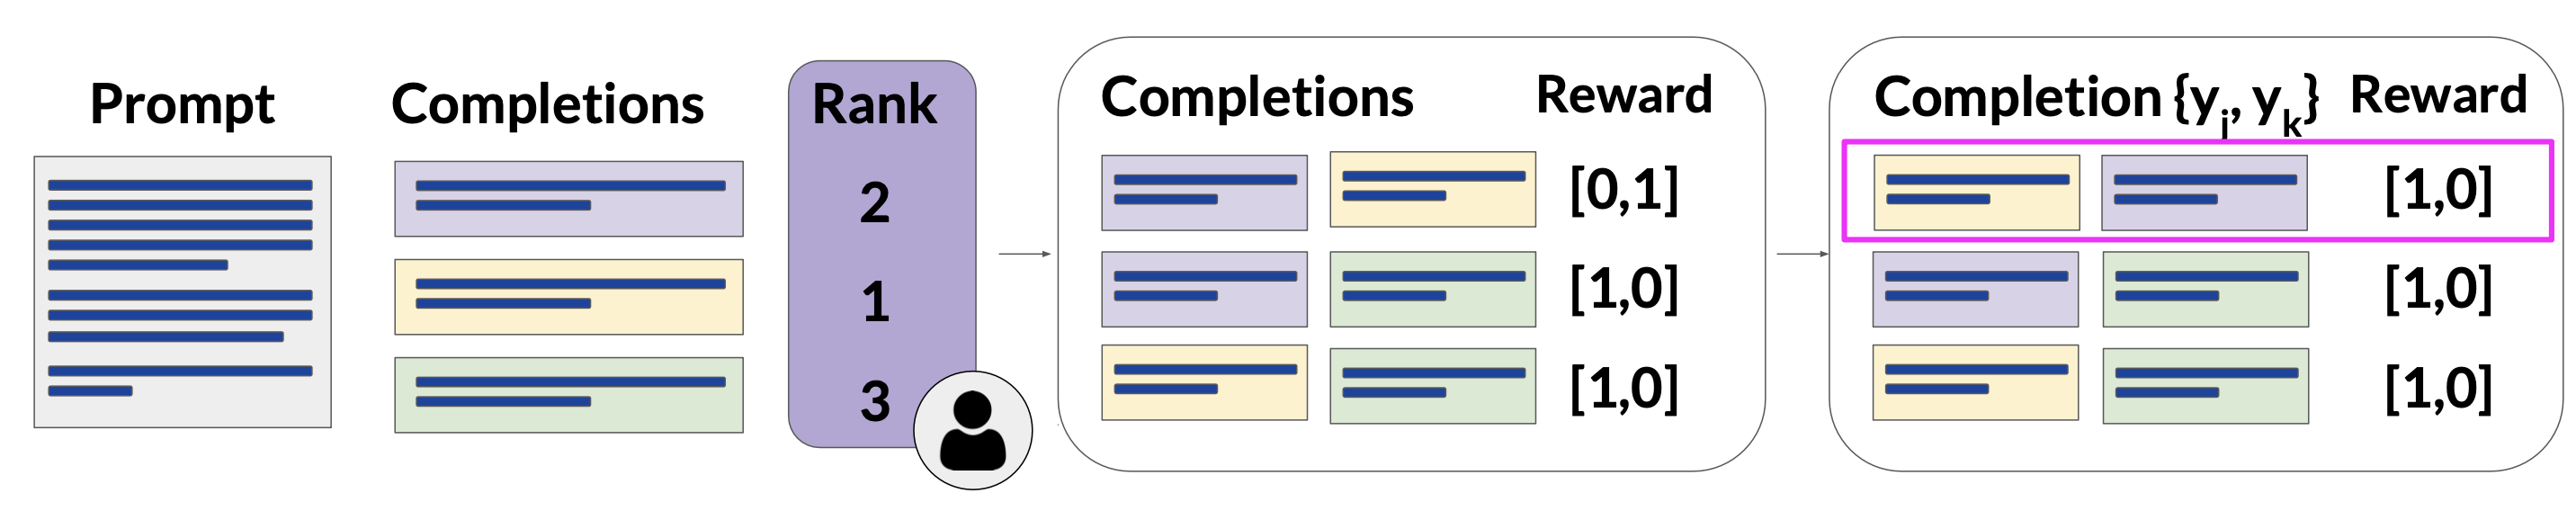

利用奖励模型和强化学习，将模型生成内容与人工价值观对齐

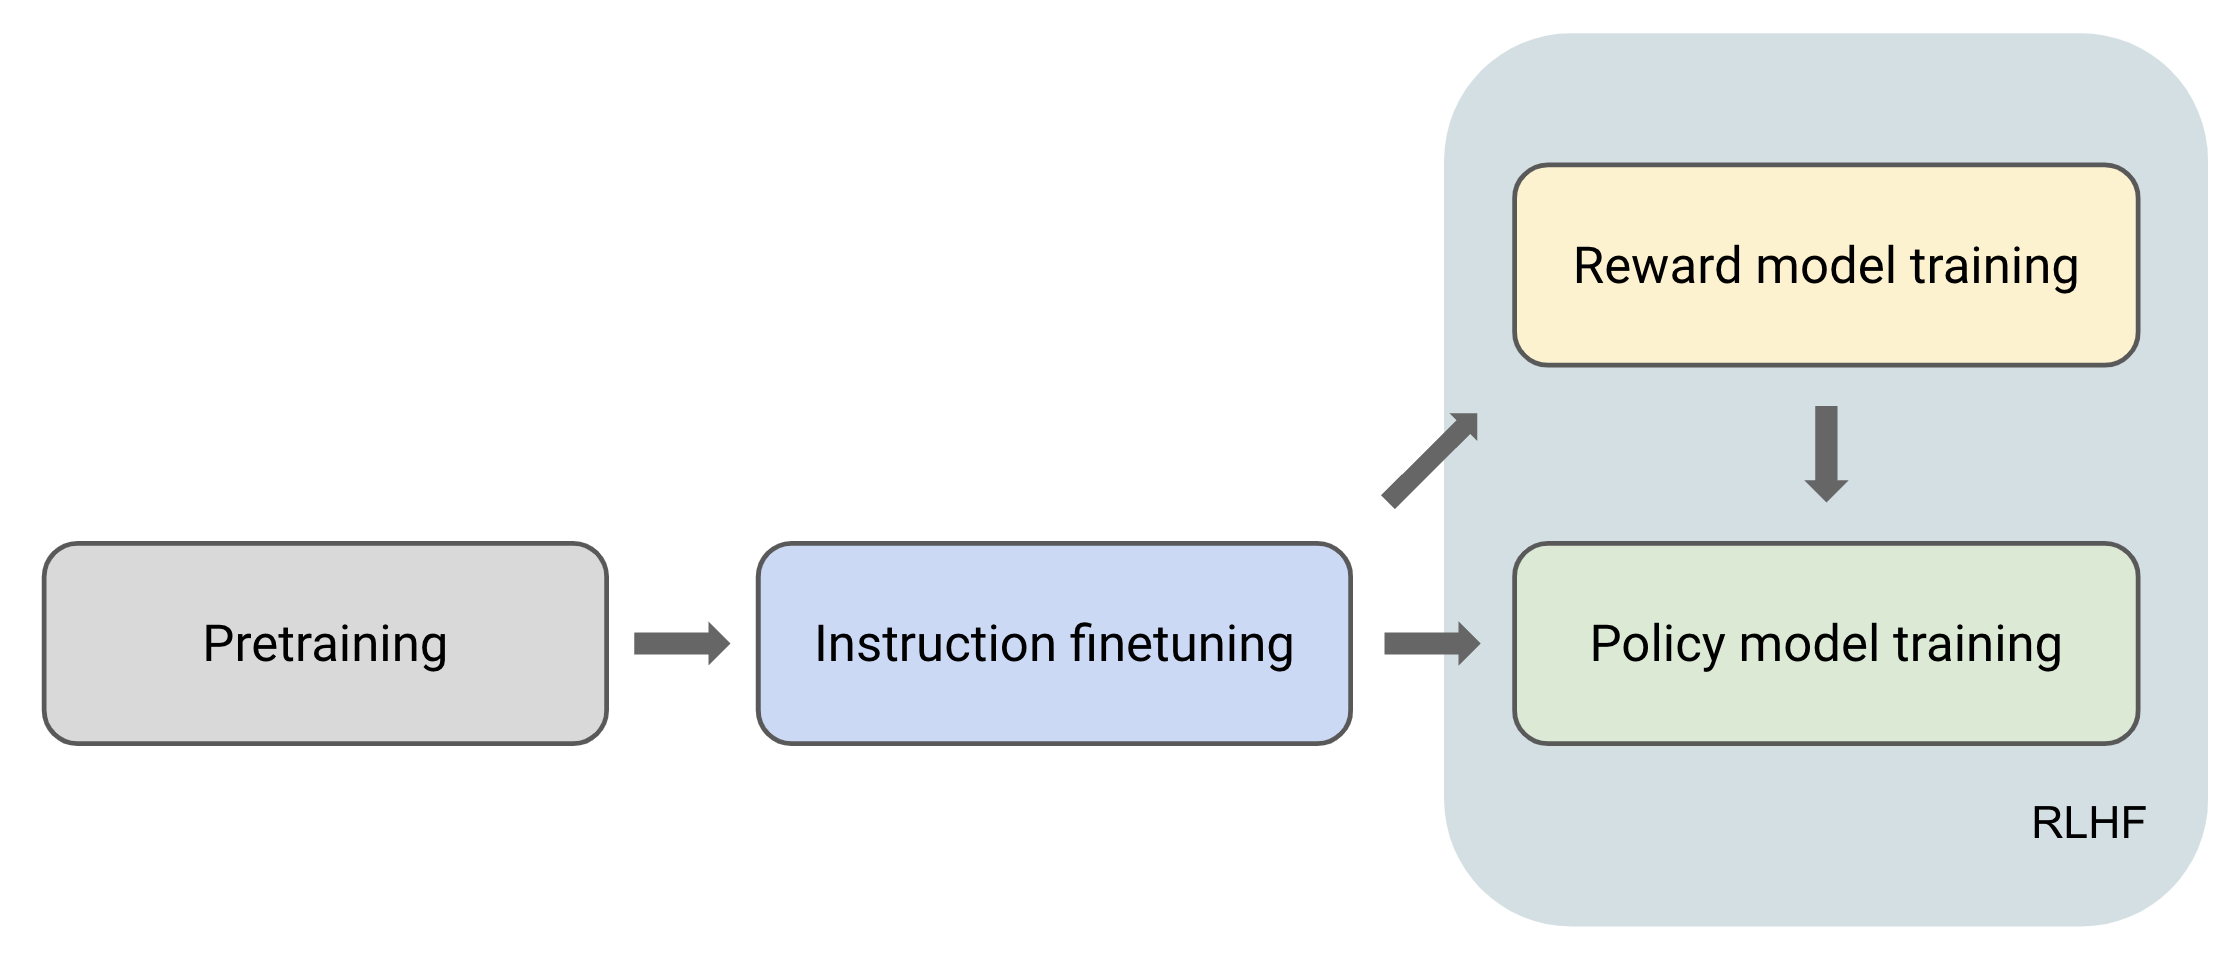

训练过程中，考虑生成内容在对齐前后的差异，防止出现Reward hacking

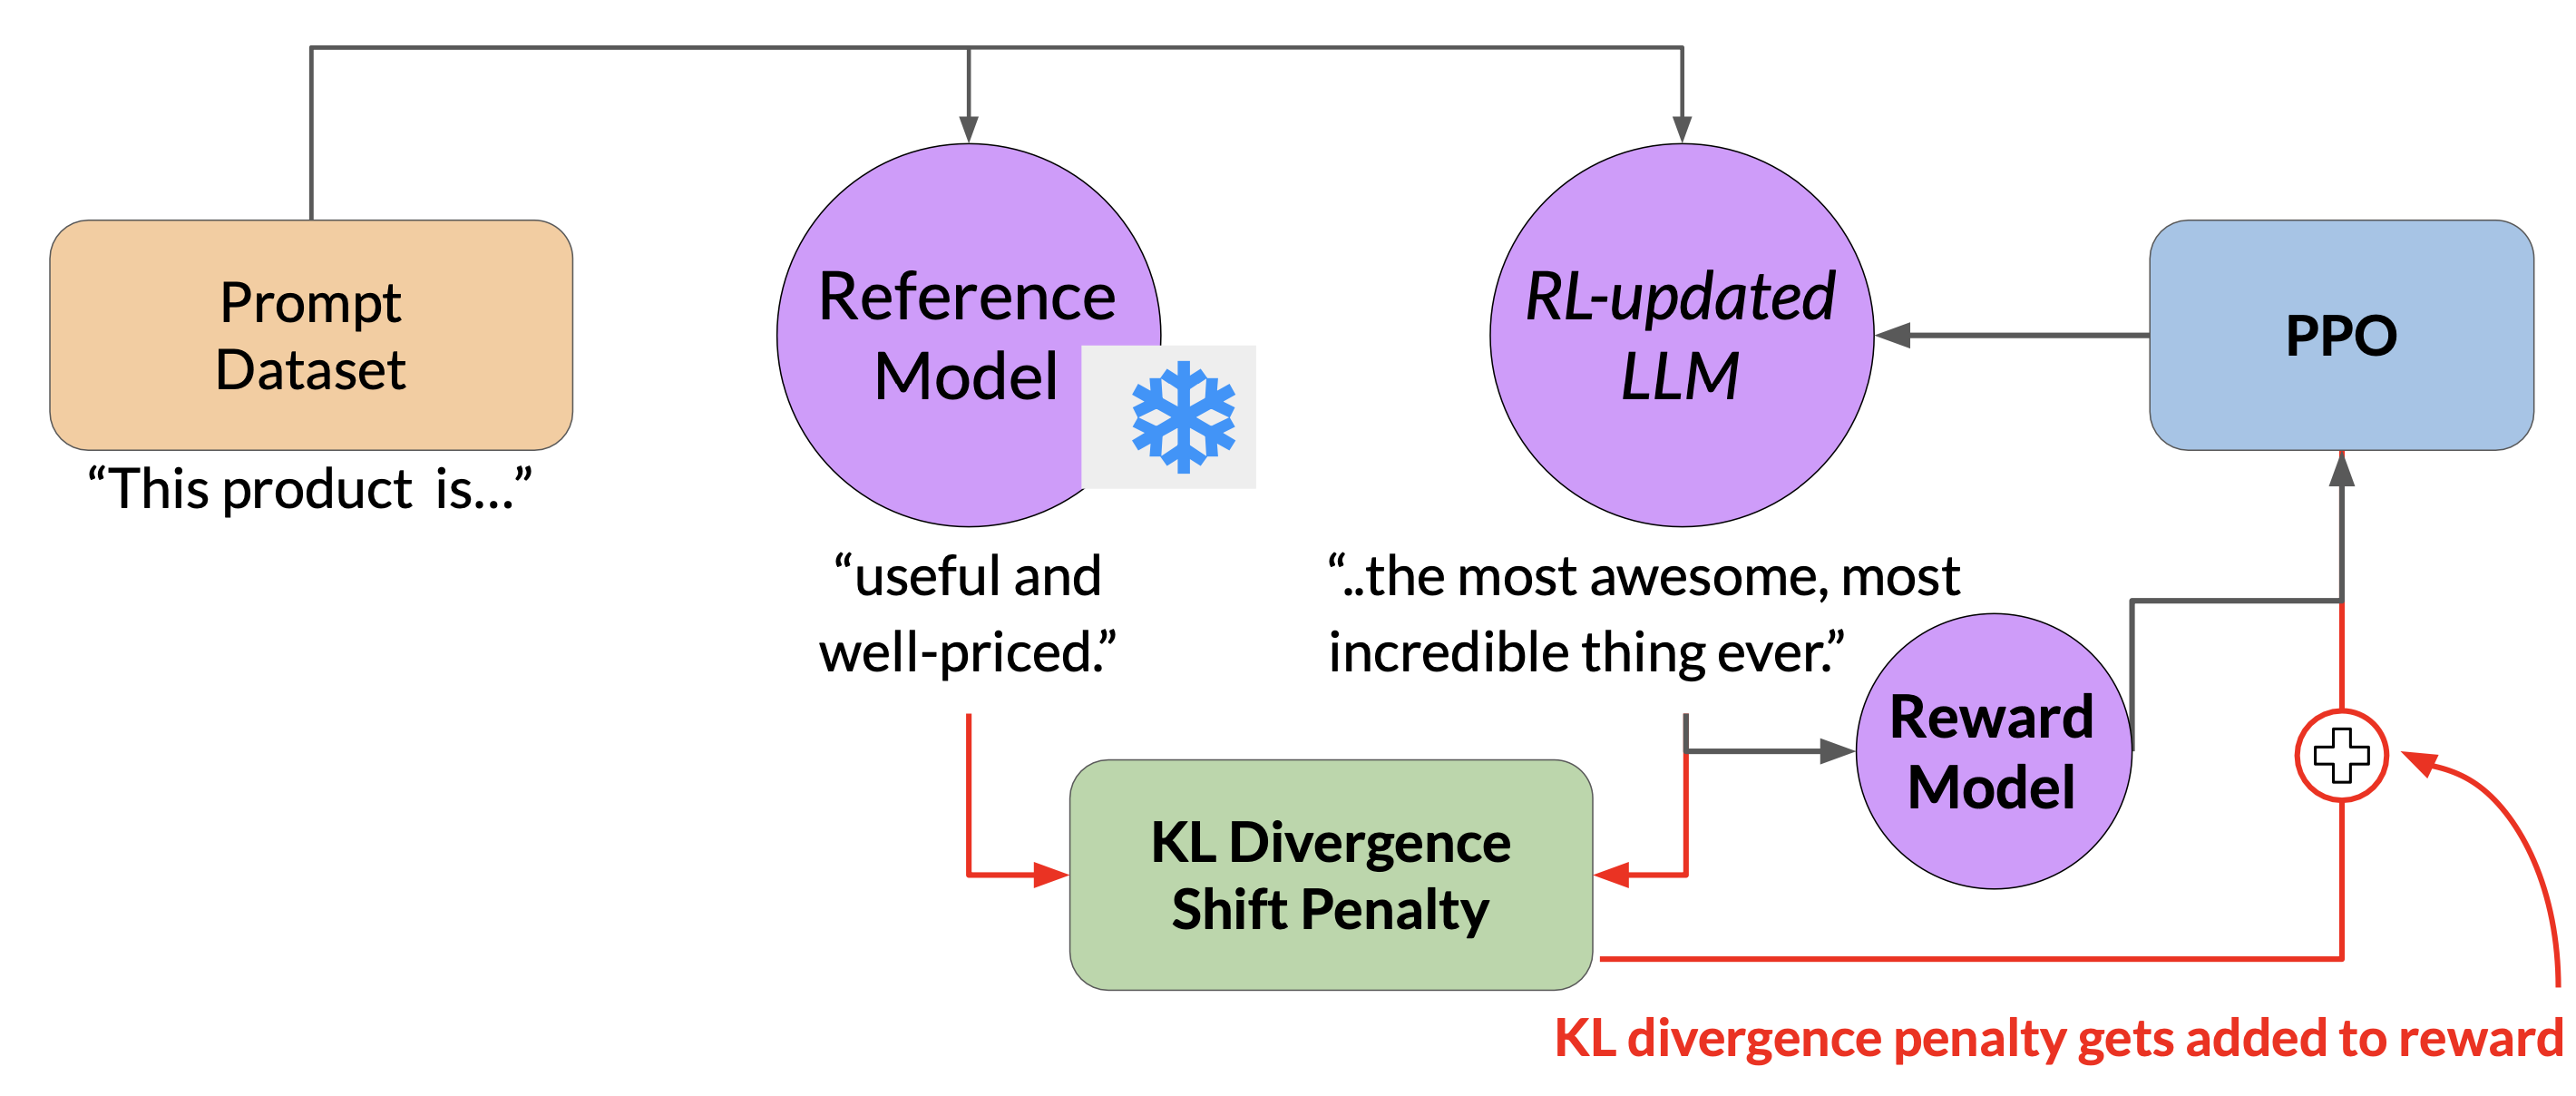

基于人工反馈的强化学习训练，可以有效解决模型的HHH（Helpful、Honest、Harmless）问题

以下将展示强化学习降低文本生成的有害性

In [38]:
# 将强化学习策略应用到大模型中
ppo_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(peft_model,
                                                               torch_dtype=torch.bfloat16,
                                                               is_trainable=True)

In [39]:
print_number_of_trainable_model_parameters(ppo_model)

trainable model parameters: 3539713
all model parameters: 251117569
percentage of trainable parameters: 1.4095839706062143%


In [40]:
# 强化学习前的大模型
ref_model = create_reference_model(ppo_model)

print_number_of_trainable_model_parameters(ref_model)

trainable model parameters: 0
all model parameters: 251117569
percentage of trainable parameters: 0.0%


In [41]:
# 奖励模型
toxicity_model_name = 'facebook/roberta-hate-speech-dynabench-r4-target'
toxicity_model = AutoModelForSequenceClassification.from_pretrained(toxicity_model_name, local_files_only=True)
toxicity_tokenizer = AutoTokenizer.from_pretrained(toxicity_model_name, local_files_only=True)

In [42]:
# overview 奖励模型效果
non_toxic_text = 'You are so beautiful.'
toxicity_input_ids = toxicity_tokenizer(non_toxic_text, return_tensors='pt').input_ids
logits = toxicity_model(input_ids=toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits}')

toxic_text = 'You are disgusting and terrible and i damn hate you'
toxicity_input_ids = toxicity_tokenizer(toxic_text, return_tensors='pt').input_ids
logits = toxicity_model(input_ids=toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

logits [not hate, hate]: tensor([[ 4.6580, -4.0786]], grad_fn=<AddmmBackward0>)
logits [not hate, hate]: [-2.061079502105713, 1.5835545063018799]


In [43]:
# pipeline封装奖励模型
sentiment_pipe = pipeline('sentiment-analysis',
                          model=toxicity_model_name)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# 预处理训练数据
min_text_length = 200
max_text_length = 1000
dataset = dataset.filter(lambda x: len(x['dialogue'])>min_text_length and len(x['dialogue'])<=max_text_length, batched=False)

def tokenize_func(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = start_prompt + example['dialogue'] + end_prompt
    example['input_ids'] = tokenizer.encode(prompt)
    example['query'] = prompt
    return example

tokenize_dataset = dataset.map(tokenize_func, batched=False)
tokenize_dataset.set_format(type='torch')

In [49]:
# 模型强化学习训练
learning_rate = 1.41e-5
max_ppo_epochs = 1
mini_batch_size = 4
batch_size = 16

config = PPOConfig(
    model_name='google/flan-t5-base',
    learning_rate=learning_rate,
    ppo_epochs=max_ppo_epochs,
    mini_batch_size=mini_batch_size,
    batch_size=batch_size
)

generation_config = {
    'min_length': 5,
    'top_k': 0.0,
    'top_p': 1.0,
    'do_sample': True
}

reward_kwargs = {
    'top_k': None,
    'function_to_apply': 'none',
    'batch_size': 16
}

def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

ppo_trainer = PPOTrainer(config=config,
                         model=ppo_model,
                         ref_model=ref_model,
                         tokenizer=tokenizer,
                         dataset=tokenize_dataset['train'],
                         data_collator=collator)

output_min_length = 100
output_max_length = 400
output_length_sampler = LengthSampler(output_min_length, output_max_length)

max_ppo_steps = 10

for step, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    if step >= max_ppo_steps:
        break

    prompt_tensors = batch['input_ids']

    summary_tensors = []

    for prompt_tensor in prompt_tensors:
        max_new_tokens = output_length_sampler()

        generation_config['max_new_tokens'] = max_new_tokens
        summary = ppo_trainer.generate(prompt_tensor, **generation_config)

        summary_tensors.append(summary.squeeze()[-max_new_tokens:])

    batch['response'] = [tokenizer.decode(r) for r in summary_tensors]

    # compute reward outputs
    query_response_pairs = [q + r for q, r in zip(batch['query'], batch['response'])]
    rewards = sentiment_pipe(query_response_pairs, **reward_kwargs)
    label_score = [{res['label']:res['score'] for res in reward} for reward in rewards]
    reward_tensors = [torch.tensor(d['nothate']) for d in label_score]

    # run PPO step
    stats = ppo_trainer.step(prompt_tensors, summary_tensors, reward_tensors)
    ppo_trainer.log_stats(stats, batch, reward_tensors)

    print(f"objective/kl: {stats['objective/kl']}")
    print(f"ppo/returns/mean: {stats['ppo/returns/mean']}")
    print(f"ppo/policy/advantages_mean: {stats['ppo/policy/advantages_mean']}")
    print('-'*100)

1it [00:12, 12.41s/it]

objective/kl: 20.937061309814453
ppo/returns/mean: -0.18709471821784973
ppo/policy/advantages_mean: 0.020716331899166107
----------------------------------------------------------------------------------------------------


2it [00:26, 13.38s/it]

objective/kl: 19.683147430419922
ppo/returns/mean: -0.08401287347078323
ppo/policy/advantages_mean: -0.0026409421116113663
----------------------------------------------------------------------------------------------------


3it [00:37, 12.40s/it]

objective/kl: 16.6783504486084
ppo/returns/mean: 0.16446956992149353
ppo/policy/advantages_mean: 0.049258023500442505
----------------------------------------------------------------------------------------------------


4it [00:49, 12.26s/it]

objective/kl: 15.109798431396484
ppo/returns/mean: 0.007998865097761154
ppo/policy/advantages_mean: 0.012215789407491684
----------------------------------------------------------------------------------------------------


5it [01:02, 12.29s/it]

objective/kl: 18.580142974853516
ppo/returns/mean: 0.005036257207393646
ppo/policy/advantages_mean: 0.05228594318032265
----------------------------------------------------------------------------------------------------


6it [01:15, 12.54s/it]

objective/kl: 20.967466354370117
ppo/returns/mean: -0.13945144414901733
ppo/policy/advantages_mean: 0.002043008804321289
----------------------------------------------------------------------------------------------------


7it [01:27, 12.35s/it]

objective/kl: 15.226810455322266
ppo/returns/mean: 0.2145734578371048
ppo/policy/advantages_mean: 0.021514050662517548
----------------------------------------------------------------------------------------------------


8it [01:39, 12.39s/it]

objective/kl: 15.967244148254395
ppo/returns/mean: 0.11599693447351456
ppo/policy/advantages_mean: 0.007274126634001732
----------------------------------------------------------------------------------------------------


9it [01:51, 12.34s/it]

objective/kl: 17.240598678588867
ppo/returns/mean: -0.0914173424243927
ppo/policy/advantages_mean: 0.017579032108187675
----------------------------------------------------------------------------------------------------


10it [02:02, 12.29s/it]

objective/kl: 18.85260581970215
ppo/returns/mean: -0.1301470249891281
ppo/policy/advantages_mean: 0.04616677761077881
----------------------------------------------------------------------------------------------------


In [52]:
# 强化学习微调后的效果比较
eval_batch = 10
eval_df = tokenize_dataset['test'][:eval_batch]

compare_results = {}
compare_results['query'] = eval_df['query']

summary_tensors = []
summary_tensors_ref = []

prompt_tensors = eval_df['input_ids']

for prompt_tensor in tqdm(prompt_tensors):
    max_new_tokens = output_length_sampler()

    generation_config['max_new_tokens'] = max_new_tokens
    summary = ppo_model.generate(input_ids=prompt_tensor.unsqueeze(dim=0).to('cuda'), **generation_config)
    summary_tensors.append(summary[0])

    summary_ref = ref_model.generate(input_ids=prompt_tensor.unsqueeze(dim=0).to('cuda'), **generation_config)
    summary_tensors_ref.append(summary_ref[0])

compare_results['RLHF_before_response'] = [tokenizer.decode(st) for st in summary_tensors_ref]
compare_results['RLHF_after_response'] = [tokenizer.decode(st) for st in summary_tensors]

texts_before = [q+r for q, r in zip(compare_results['query'], compare_results['RLHF_before_response'])]
rewards_before = sentiment_pipe(texts_before, **reward_kwargs)
before_label_score = [{res['label']:res['score'] for res in reward} for reward in rewards_before]
compare_results['rewards_before'] = [d['nothate'] for d in before_label_score]

texts_after = [q+r for q, r in zip(compare_results['query'], compare_results['RLHF_after_response'])]
rewards_after = sentiment_pipe(texts_after, **reward_kwargs)
after_label_score = [{res['label']:res['score'] for res in reward} for reward in rewards_after]
compare_results['rewards_after'] = [d['nothate'] for d in after_label_score]

pd.set_option('display.max_colwidth', 500)
df_compare_results = pd.DataFrame(compare_results)
df_compare_results.head(20)

100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


query  \
0  Summarize the following conversation.\n\n#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n...   
1  Summarize the following conversation.\n\n#Person1#: Hello Mrs. Parker, how have you been?\n#Person2#: Hello Dr. Peters. Just fine thank you. Ricky and I are here for his vaccines.\n#Person1#: Very well. Let's see, according to his vaccination record, Ricky has received his Polio, Tetanus and Hepatitis B shots. He is 14 months old, so he is due for Hepatitis A, Chickenpox and Measles shots.\n#Person2#: What about Rubella and Mumps?\n#Person1#: Well, I can only give him these for now, and afte...   
2  Summarize the following conversation.\n\n#Person1#: Excuse me, did you see a set of keys?\n#Person2#: What kind of keys?\n#Person1#: Five keys and a small foot ornament.\n#Person2#: What a shame! I didn't see them.\n#Person1#: Well, can you help me look for it? That's my first time here.\n#Person2#: Sure. It's my pleasure. I'd like to help you look for the missing keys.\n#Person1#: It's very kind of you.\n#Person2#: It's not a big deal.Hey, I found them.\n#Person1#: Oh, thank God! I don't kn...   
3  Summarize the following conversation.\n\n#Person1#: Why didn't you tell me you had a girlfriend?\n#Person2#: Sorry, I thought you knew.\n#Person1#: But you should tell me you were in love with her.\n#Person2#: Didn't I?\n#Person1#: You know you didn't.\n#Person2#: Well, I am telling you now.\n#Person1#: Yes, but you might have told me before.\n#Person2#: I didn't think you would be interested.\n#Person1#: You can't be serious. How dare you not tell me you are going to marry her?\n#Person2#: ...   
4  Summarize the following conversation.\n\n#Person1#: Watsup, ladies! Y'll looking'fine tonight. May I have this dance?\n#Person2#: He's cute! He looks like Tiger Woods! But, I can't dance. . .\n#Person1#: It's all good. I'll show you all the right moves. My name's Malik.\n#Person2#: Nice to meet you. I'm Wen, and this is Nikki.\n#Person1#: How you feeling', vista? Mind if I take your friend'round the dance floor?\n#Person2#: She doesn't mind if you don't mind getting your feet stepped on.\n#P...   
5                                                                                                                                            Summarize the following conversation.\n\n#Person1#: Happy birthday, Aims!\n#Person2#: Thank you, Lisa.\n#Person1#: Here is a present for you. I hope you like it.\n#Person2#: Oh, great! I love it! You know I've been expecting this for a long time.\n#Person1#: I'm very glad to hear that.\n#Person2#: Come here ; let me introduce some friends to you.\n\nSummary:    
6                                                                                                                                                                        Summarize the following conversation.\n\n#Person1#: Here we come.\n#Person2#: Thank you. What's the fare?\n#Person1#: $ 10.\n#Person2#: How can it be?\n#Person1#: Well, the rate is two dollars for the first two kilometers and twenty cents for each additional two hundred meters.\n#Person2#: I see. Thanks for your drive.\n\nSummary:    
7  Summarize the following conversation.\n\n#Person1#: This is a good basic computer package. It's got a good CPU, 256 megabytes of RAM, and a DVD player.\n#Person2#: Does it come with a modem?\n#Person1#: Yes, it has a built-in modem. You just plug a phone line into the back of the computer.\n#Person2#: How about the monitor?\n#Person1#: A 15 - inch monitor is included in the deal. If you want, you can switch it for a 17 - inch monitor, for a l

In [53]:
df_compare_results[['rewards_before', 'rewards_after']].mean()

rewards_before    2.021209
rewards_after     2.192808
dtype: float64

## 开发应用

### Retrieval augmented generation（RAG）

- 接入外部知识，包括文本、数据库、Web
- 解决模型的out of date问题
- 缓解模型的幻觉（Hallucination）问题

### Program-aided language model (PAL)

- 赋予语言模型工具调用的能力
- 增强模型的数学计算问题

### Reasoning and Acting (ReAct)

- 使模型可以通过多次推理和执行动作（如：网页搜索）去解决一些复杂的问题

例如：当需要确认广告的CPC为什么上升的问题时，大模型可以通过先推理哪些指标会对CPC有影响，然后分别执行数据库统计，计算所有相关指标，再通过比较指标的变化推理是哪些指标的变化导致了CPC上升

...

## 提升生产环境中的模型性能

- 降低模型部署所需要的存储
  
- 实现边缘计算

- 加快线上服务的推理速度

- 降低成本

  ...

### 降低精度

FP32 -> FP16/BFLOAT16/INT8

### 知识蒸馏

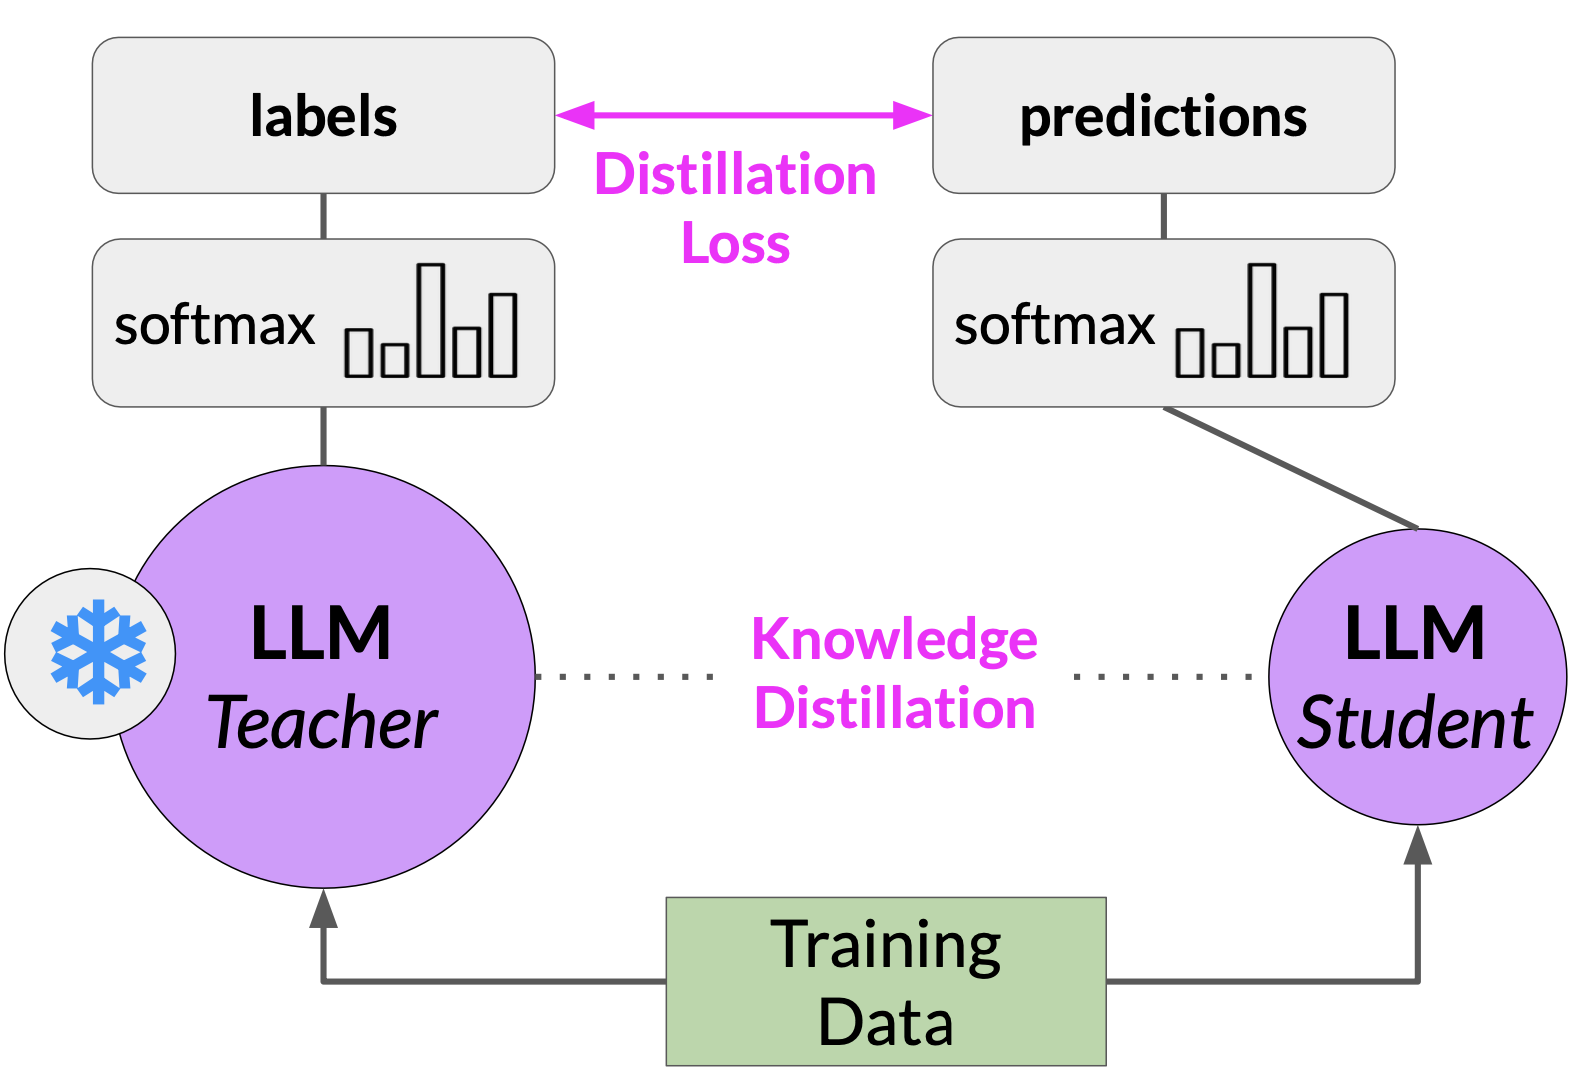

### 模型剪枝

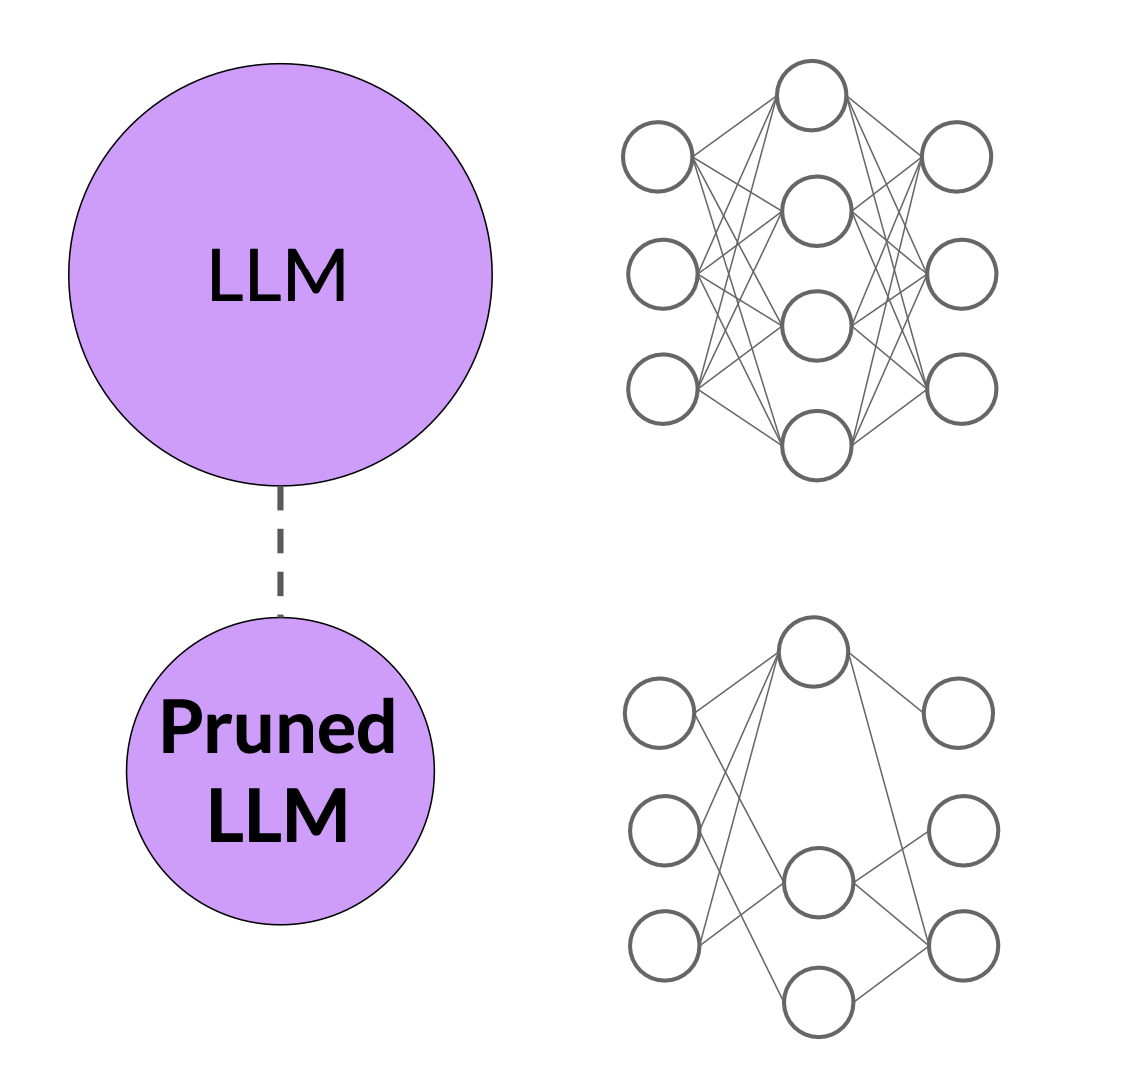

## 保持探索

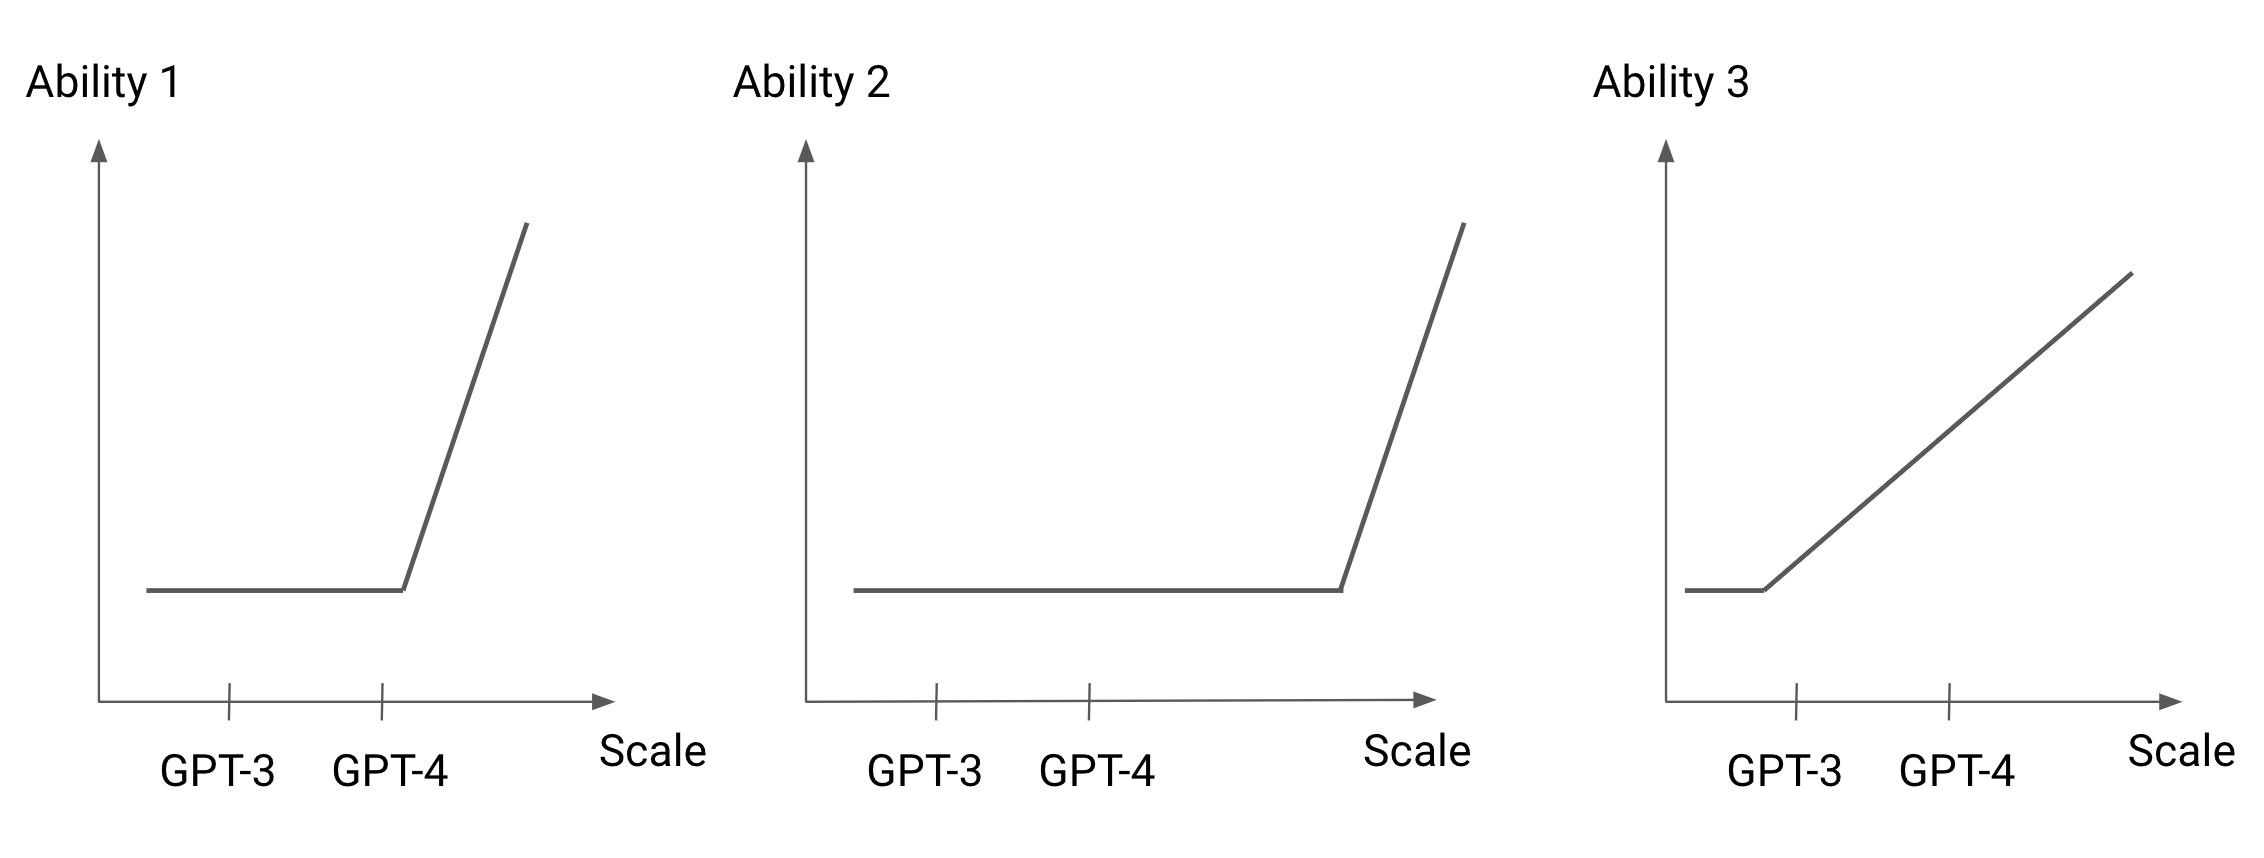

大模型的能力涌现现象需要我们持续保持好奇心；当前大模型做不了的，不代表未来做不了；当前大模型效果差的，不代表未来不能提升。